# <font color='Teal'> **ТЕМА 1. ЗАДАЧИ ПРЕДИКТИВНОГО МОДЕЛИРОВАНИЯ И РАСШИРЕННАЯ БИЗНЕС-АНАЛИТИКА**

##<font color='Teal'> **ЛАБОРАТОРНАЯ РАБОТА 1**

Целью лабораторной работы является разработка и валидация алгоритмического конвейера для предиктивного моделирования, который интегрирует методы машинного обучения для регрессионного анализа ценообразования автомобилей. Задача охватывает обработку исходного набора данных с последующим их разбиением на числовые и категориальные переменные, очистку от дубликатов и заполнение отсутствующих значений. Процесс предполагает аналитический обзор распределений и корреляций между переменными.

Ключевой аспект — создание конвейера, который автоматически оптимизирует процесс выбора методов кодирования категориальных признаков и методов нормализации числовых данных для повышения предсказательной способности регрессионных моделей. Конвейер должен демонстрировать способность к обучению на разнообразных моделях регрессии и выбору наиболее адекватной модели на основе показателей качества предсказаний.

В результате будет создана система, позволяющая не только эффективно предсказывать рыночную стоимость автомобилей, но и обладающая функциональностью для визуализации данных, оценки точности моделей, а также интерфейсом для онлайн-оценки стоимости транспортных средств. Эта система будет способствовать принятию обоснованных решений в области ценообразования и управления автопарком.

###<font size=6 color='Teal'> Подготовка среды и данных

In [99]:
!pip install category_encoders

In [252]:
import math
import os
import warnings

from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools import add_constant
from category_encoders import TargetEncoder
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import (ExtraTreesRegressor,
                              GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import (ElasticNetCV,
                                  Lasso, LassoCV,
                                  LinearRegression,
                                  Ridge,
                                  RidgeCV)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (LabelEncoder,
                                   MinMaxScaler,
                                   Normalizer,
                                   RobustScaler,
                                   StandardScaler)
from sklearn.svm import SVR
from IPython.display import display
from ipywidgets import Button, Dropdown, FloatSlider, Layout, RadioButtons

%matplotlib inline

warnings.filterwarnings("ignore")

In [101]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [253]:
def read_file(file_path, sep, encoding):
    """
    Загружает данные из CSV-файла, удаляет дубликаты и возвращает DataFrame.
    """
    df = pd.read_csv(file_path, sep=sep, encoding=encoding)
    df = df.drop_duplicates()
    return df

In [254]:
df = read_file("/content/drive/MyDrive/Предиктивная аналитика/cars_encoded.csv", sep=';', encoding='windows-1251')

In [255]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,...,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen,Unnamed: 20
0,24.03.2016 11:52,Golf_3_1.6,privat,Angebot,480.000000,test,NaN,1993.000000,manuell,0.000000,...,150000.000000,0.000000,benzin,volkswagen,NaN,24.03.2016 0:00,0.000000,70435.000000,07.04.2016 3:16,NaN
1,24.03.2016 10:58,A5_Sportback_2.7_Tdi,privat,Angebot,18300.000000,test,coupe,2011.000000,manuell,190.000000,...,125000.000000,5.000000,diesel,audi,ja,24.03.2016 0:00,0.000000,66954.000000,07.04.2016 1:46,NaN
2,14.03.2016 12:52,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800.000000,test,suv,2004.000000,automatik,163.000000,...,125000.000000,8.000000,diesel,jeep,NaN,14.03.2016 0:00,0.000000,90480.000000,05.04.2016 12:47,NaN
3,17.03.2016 16:54,GOLF_4_1_4__3TЬRER,privat,Angebot,1500.000000,test,kleinwagen,2001.000000,manuell,75.000000,...,150000.000000,6.000000,benzin,volkswagen,nein,17.03.2016 0:00,0.000000,91074.000000,17.03.2016 17:40,NaN
4,31.03.2016 17:25,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600.000000,test,kleinwagen,2008.000000,manuell,69.000000,...,90000.000000,7.000000,diesel,skoda,nein,31.03.2016 0:00,0.000000,60437.000000,06.04.2016 10:17,NaN


In [256]:
df.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen', 'Unnamed: 20'],
      dtype='object')

In [257]:
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,...,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen,Unnamed: 20
0,24.03.2016 11:52,Golf_3_1.6,privat,Angebot,480.000000,test,NaN,1993.000000,manuell,0.000000,...,150000.000000,0.000000,benzin,volkswagen,NaN,24.03.2016 0:00,0.000000,70435.000000,07.04.2016 3:16,NaN
1,24.03.2016 10:58,A5_Sportback_2.7_Tdi,privat,Angebot,18300.000000,test,coupe,2011.000000,manuell,190.000000,...,125000.000000,5.000000,diesel,audi,ja,24.03.2016 0:00,0.000000,66954.000000,07.04.2016 1:46,NaN
2,14.03.2016 12:52,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800.000000,test,suv,2004.000000,automatik,163.000000,...,125000.000000,8.000000,diesel,jeep,NaN,14.03.2016 0:00,0.000000,90480.000000,05.04.2016 12:47,NaN
3,17.03.2016 16:54,GOLF_4_1_4__3TЬRER,privat,Angebot,1500.000000,test,kleinwagen,2001.000000,manuell,75.000000,...,150000.000000,6.000000,benzin,volkswagen,nein,17.03.2016 0:00,0.000000,91074.000000,17.03.2016 17:40,NaN
4,31.03.2016 17:25,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600.000000,test,kleinwagen,2008.000000,manuell,69.000000,...,90000.000000,7.000000,diesel,skoda,nein,31.03.2016 0:00,0.000000,60437.000000,06.04.2016 10:17,NaN


Price - целевая переменная. Задача регрессии.
Найдем переменные, которые переменные не могут влиять или влияют слабо на формирование цены:
* dateCrawled
* name
* nrOfPictures
* postalCode
* lastSeen
* dateCreated (дата когда было создано объявление)
* monthOfRegistration (думаю для цены не важно в каком месяце произошла регистрация авто)

Удалим их:


In [258]:
df.drop(['dateCrawled', 'name', 'nrOfPictures', 'postalCode', 'lastSeen', 'dateCreated', 'monthOfRegistration'], axis=1, inplace=True)

In [259]:
df.drop(['Unnamed: 20'], axis=1, inplace=True) # ошибка при чтении

In [260]:
df.head()

,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
0,privat,Angebot,480.000000,test,NaN,1993.000000,manuell,0.000000,golf,150000.000000,benzin,volkswagen,NaN
1,privat,Angebot,18300.000000,test,coupe,2011.000000,manuell,190.000000,NaN,125000.000000,diesel,audi,ja
2,privat,Angebot,9800.000000,test,suv,2004.000000,automatik,163.000000,grand,125000.000000,diesel,jeep,NaN
3,privat,Angebot,1500.000000,test,kleinwagen,2001.000000,manuell,75.000000,golf,150000.000000,benzin,volkswagen,nein
4,privat,Angebot,3600.000000,test,kleinwagen,2008.000000,manuell,69.000000,fabia,90000.000000,diesel,skoda,nein


In [261]:
df['seller'].value_counts()

seller
privat                     371366
gewerblich                      3
_meinen_kleinen_Flitzer         1
Name: count, dtype: int64

In [262]:
df[df['seller'] == '_meinen_kleinen_Flitzer']

,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
49602,_meinen_kleinen_Flitzer,privat,Angebot,1100,test,kleinwagen,2001,manuell,65,corsa,9,benzin,opel


In [263]:
# Удалим записи, которые ,вероятно, ошибочно считались
df.drop(df[df['seller'] != 'privat'].index, axis=0, inplace=True)
# И также удалим колонку seller
df.drop(['seller'], axis=1, inplace=True)

In [264]:
df['offerType'].value_counts()

offerType
Angebot    371354
Gesuch         12
Name: count, dtype: int64

In [265]:
df[df['offerType'] == 'Gesuch'].head(3)

,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
16744,Gesuch,0.000000,test,bus,2005.000000,NaN,0.000000,transporter,150000.000000,NaN,volkswagen,NaN
90921,Gesuch,19999.000000,control,NaN,1990.000000,NaN,0.000000,golf,5000.000000,NaN,volkswagen,NaN
144450,Gesuch,0.000000,test,coupe,2004.000000,manuell,0.000000,3er,150000.000000,benzin,bmw,nein


In [266]:
# Аналогично удалим колонку, так как преобладает одна категория (можно сказать все объекты одной категории)
df.drop(['offerType'], axis=1, inplace=True)

In [267]:
df['price'].isna().sum() # Все значения заполненеы, значит не придется удалять записи по этому признаку

0

In [268]:
df.dtypes

price                 object
abtest                object
vehicleType           object
yearOfRegistration    object
gearbox               object
powerPS               object
model                 object
kilometer             object
fuelType              object
brand                 object
notRepairedDamage     object
dtype: object

In [269]:
df.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
0,480.000000,test,NaN,1993.000000,manuell,0.000000,golf,150000.000000,benzin,volkswagen,NaN
1,18300.000000,test,coupe,2011.000000,manuell,190.000000,NaN,125000.000000,diesel,audi,ja
2,9800.000000,test,suv,2004.000000,automatik,163.000000,grand,125000.000000,diesel,jeep,NaN
3,1500.000000,test,kleinwagen,2001.000000,manuell,75.000000,golf,150000.000000,benzin,volkswagen,nein
4,3600.000000,test,kleinwagen,2008.000000,manuell,69.000000,fabia,90000.000000,diesel,skoda,nein


In [270]:
df['notRepairedDamage'].unique()

array([nan, 'ja', 'nein'], dtype=object)

In [271]:
# Преобразуем типы данных столбцов
df = df.astype({
    'price': 'float64',
    'powerPS': 'float64',
    'kilometer': 'float64',
    'yearOfRegistration': 'int'
})

In [272]:
df['abtest'].value_counts() # норм

abtest
test       192516
control    178850
Name: count, dtype: int64

In [273]:
df['abtest'].isna().sum() # хорошо

0

In [274]:
df.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
0,480.000000,test,NaN,1993,manuell,0.000000,golf,150000.000000,benzin,volkswagen,NaN
1,18300.000000,test,coupe,2011,manuell,190.000000,NaN,125000.000000,diesel,audi,ja
2,9800.000000,test,suv,2004,automatik,163.000000,grand,125000.000000,diesel,jeep,NaN
3,1500.000000,test,kleinwagen,2001,manuell,75.000000,golf,150000.000000,benzin,volkswagen,nein
4,3600.000000,test,kleinwagen,2008,manuell,69.000000,fabia,90000.000000,diesel,skoda,nein


## Работа с пропусками

In [275]:
df.isna().sum()

price                     0
abtest                    0
vehicleType           37854
yearOfRegistration        0
gearbox               20202
powerPS                   0
model                 20475
kilometer                 0
fuelType              33376
brand                     0
notRepairedDamage     72026
dtype: int64

In [276]:
df['vehicleType'].value_counts()

vehicleType
limousine     95847
kleinwagen    79988
kombi         67543
bus           30186
cabrio        22891
coupe         18999
suv           14698
andere         3360
Name: count, dtype: int64

In [277]:
str(list(df['fuelType'].unique())).replace("'", '')

'[benzin, diesel, nan, lpg, andere, hybrid, cng, elektro]'

In [278]:
df['powerPS']

0          0.000000
1        190.000000
2        163.000000
3         75.000000
4         69.000000
            ...    
371819     0.000000
371820   101.000000
371821   102.000000
371822   100.000000
371823   320.000000
Name: powerPS, Length: 371366, dtype: float64

In [279]:
"""'volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'porsche', 'toyota', 'chevrolet',
       'dacia', 'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'land_rover', 'lada'""".replace("'", '').replace('\n', '')

'volkswagen, audi, jeep, skoda, bmw, peugeot, ford,       mazda, nissan, renault, mercedes_benz, opel, seat,       citroen, honda, fiat, mini, smart, hyundai,       sonstige_autos, alfa_romeo, subaru, volvo, mitsubishi,       kia, suzuki, lancia, porsche, toyota, chevrolet,       dacia, daihatsu, trabant, saab, chrysler, jaguar,       daewoo, rover, land_rover, lada'

In [280]:
df.isna().sum() / df.count()

price                0.000000
abtest               0.000000
vehicleType          0.113501
yearOfRegistration   0.000000
gearbox              0.057529
powerPS              0.000000
model                0.058351
kilometer            0.000000
fuelType             0.098748
brand                0.000000
notRepairedDamage    0.240616
dtype: float64

In [281]:
# Удалим пропуски, и посмотрим сколько % потеряется
df_droped_na = df.dropna()

In [282]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)

In [283]:
anomal_cheap_mask = (df_droped_na['price'] < df['price'].quantile(0.05)) # удалим аномально дешевые машины
anomal_cheap_mask.sum()

5451

In [284]:
df_droped_na.drop(df_droped_na[anomal_cheap_mask].index, axis=0, inplace=True)

In [285]:
anomal_rich_mask = (df_droped_na['price'] > df_droped_na['price'].quantile(0.98)) # удалим аномально дорогие машины
anomal_rich_mask.sum()

5058

In [286]:
df_droped_na.drop(df_droped_na[anomal_rich_mask].index, axis=0, inplace=True)

In [287]:
len(df_droped_na)

250335

In [288]:
len(df_droped_na) / len(df) # Потеря данных = 33% - вполне приемлемо с учетом удаления аномальных значений

0.6740924047974236

In [289]:
df = df_droped_na

In [290]:
df.shape

(250335, 11)

In [291]:
df.isna().sum()

price                 0
abtest                0
vehicleType           0
yearOfRegistration    0
gearbox               0
powerPS               0
model                 0
kilometer             0
fuelType              0
brand                 0
notRepairedDamage     0
dtype: int64

###<font size=6 color='Teal'> Обработка данных

Функция `get_cols()` определяет и возвращает два списка столбцов: категориальные и числовые переменные. Она использует информацию о типах данных DataFrame для фильтрации столбцов:
- категориальные переменные имеют тип `object`;
- числовые переменные включают в себя все остальные типы.

In [292]:
def get_cols(df) -> list:
    """
    Функция возвращает список категориальных и числовых переменных.
    """
    categorical_feature_mask = df.dtypes == object
    number_feature_mask = df.dtypes != object
    numbers_cols = df.columns[number_feature_mask].tolist()
    categorical_cols = df.columns[categorical_feature_mask].tolist()
    return [numbers_cols, categorical_cols]

Отбор столбцов, где менее 20% данных отсутствуют, и создание нового DataFrame с этими столбцами:



In [ ]:
cols = df.apply(lambda x: f'{(x.isna().sum()/df.shape[0]).round(2)} %').sort_values().index.to_list()
df = df[cols]

# Вывод случайной строки из обновленного DataFrame для предварительного просмотра
df.sample(1)

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
504,19900.0,control,bus,2009,manuell,150.0,viano,90000.0,diesel,mercedes_benz,nein


Получение списков числовых и категориальных колонок с использованием ранее определенной функции `get_cols()`:


In [ ]:
numbers_cols, categorical_cols = get_cols(df)

Подсчет и вывод количества пропущенных значений в каждом числовом столбце:

In [ ]:
df[numbers_cols].apply(lambda x: x.isna().sum())

price                 0
yearOfRegistration    0
powerPS               0
kilometer             0
dtype: int64

Замена пропущенных значений в числовых столбцах на среднее значение по этому столбцу и преобразование типов данных столбца в `float` для обеспечения совместимости с числовыми операциями:


In [ ]:
for col in df[numbers_cols].columns.to_list():
    df[col] = df[col].fillna(df[col].mean())
    df[col] = df[col].astype('float')

# Проверка на отсутствие пропущенных значений в числовых столбцах после заполнения пропусков
df[numbers_cols].apply(lambda x: x.isna().sum())

price                 0
yearOfRegistration    0
powerPS               0
kilometer             0
dtype: int64

In [ ]:
df.columns

Index(['price', 'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox',
       'powerPS', 'model', 'kilometer', 'fuelType', 'brand',
       'notRepairedDamage'],
      dtype='object')

In [ ]:
df.sample(1)

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
92447,2290.0,test,limousine,2005.0,manuell,90.0,leon,150000.0,diesel,seat,ja


Сохранение обработанных данных в файл:

In [ ]:
df.to_csv('cars_v01.csv')

###<font size=6 color='Teal'> Визуализация данных

Определение палитры цветов:

In [293]:
colors = {
    'cur_price': '#bb5ee6',
    'fuel': 'mako_r',
    'transmission_type': 'binary_r',
    'retailer': 'Blues',
    'town': 'PuBuGn_r',
    'brand': 'OrRd',
    'car_type': 'plasma_r'
    }

Визуализация распределения типов данных, которая позволяет понять соотношение различных типов данных:

<Axes: title={'center': 'Распредление данных по типам'}, ylabel='count'>

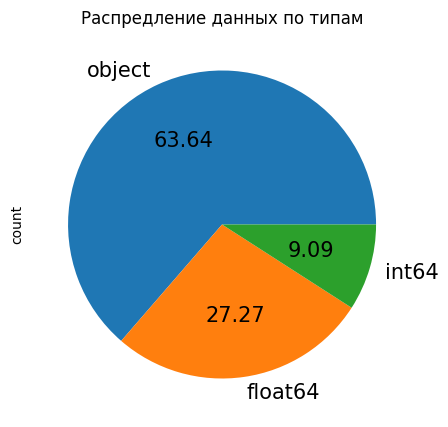

In [294]:
pd.Series([df[i].dtype for i in df.columns]).value_counts().plot(
    kind='pie',
    autopct='%.2f',
    title='Распредление данных по типам',
    fontsize=15,
    figsize=(5, 5)
    )

Круговая диаграмма демонстрирует, что в датасете преобладают категориальные данные

Вывод массива уникальных марок автомобилей, чтобы понять разнообразие автомобильных брендов в наборе данных:

In [295]:
df.head()

,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
3,1500.000000,test,kleinwagen,2001,manuell,75.000000,golf,150000.000000,benzin,volkswagen,nein
4,3600.000000,test,kleinwagen,2008,manuell,69.000000,fabia,90000.000000,diesel,skoda,nein
5,650.000000,test,limousine,1995,manuell,102.000000,3er,150000.000000,benzin,bmw,ja
6,2200.000000,test,cabrio,2004,manuell,109.000000,2_reihe,150000.000000,benzin,peugeot,nein
10,2000.000000,control,limousine,2004,manuell,105.000000,3_reihe,150000.000000,benzin,mazda,nein


In [296]:
df['brand'].unique()

array(['volkswagen', 'skoda', 'bmw', 'peugeot', 'mazda', 'nissan',
       'renault', 'ford', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'mini', 'opel', 'smart', 'audi', 'alfa_romeo', 'subaru',
       'mitsubishi', 'hyundai', 'volvo', 'lancia', 'porsche', 'citroen',
       'toyota', 'kia', 'chevrolet', 'dacia', 'suzuki', 'daihatsu',
       'chrysler', 'jaguar', 'rover', 'jeep', 'saab', 'daewoo',
       'land_rover', 'trabant', 'lada'], dtype=object)

Создание столбчатой диаграммы, иллюстрирующей количество автомобилей каждой марки в наборе данных:

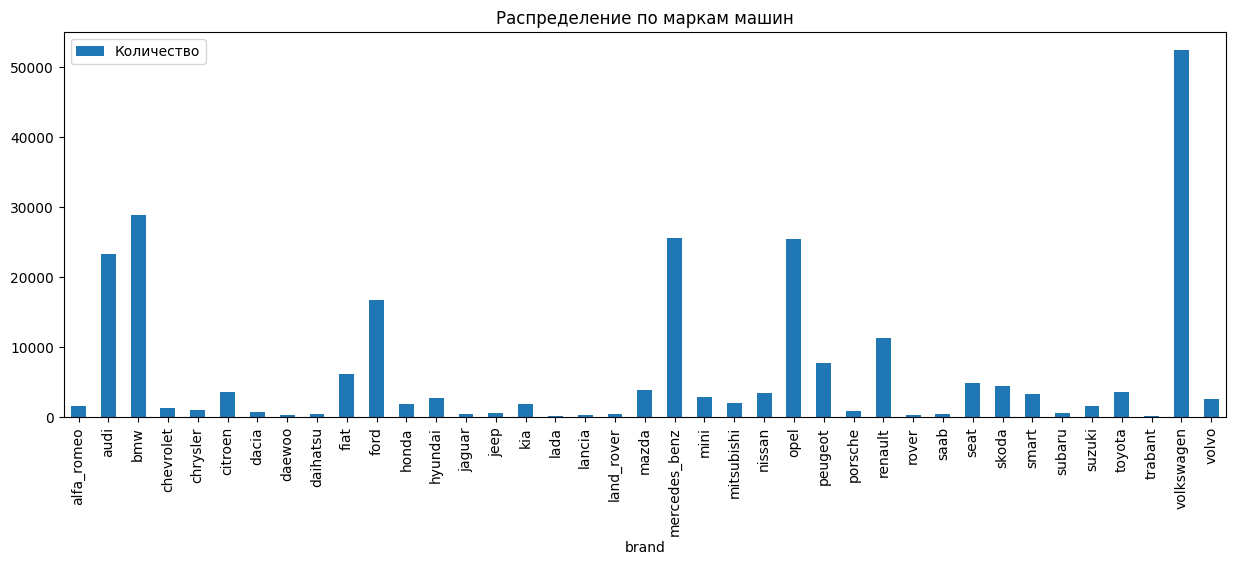

In [297]:
plt.figure(figsize=(16, 8))
df.groupby(['brand']).size().plot(
    kind='bar',
    figsize=(15,5),
    title='Распределение по маркам машин',
    label='Количество')
plt.legend()

Столбчатая диаграмма показывает распределение количества автомобилей по различным маркам. Некоторые марки имеют значительно большее количество автомобилей по сравнению с другими, что видно по высоте столбцов. Диаграмма дает наглядное представление о популярности отдельных марок и может быть полезна для анализа рыночного распределения или планирования инвентаря для автомобильных дилеров.

Выведем медианную стоимость автомобилей в наборе данных. Затем инициализируем комплексную фигуру с двумя подграфиками.

На первом подграфике создадим график плотности распределения цен (KDE plot) для визуализации распределения цен автомобилей. На втором подграфике отобразим boxplot (ящик с усами), иллюстрирующий распределение цен, включая медиану, квартили и выбросы.

Оба графика используют форматировщик `fmtr` для осей, что облегчит чтение значений.

Медианная стоимость машин составила 3850 долларов


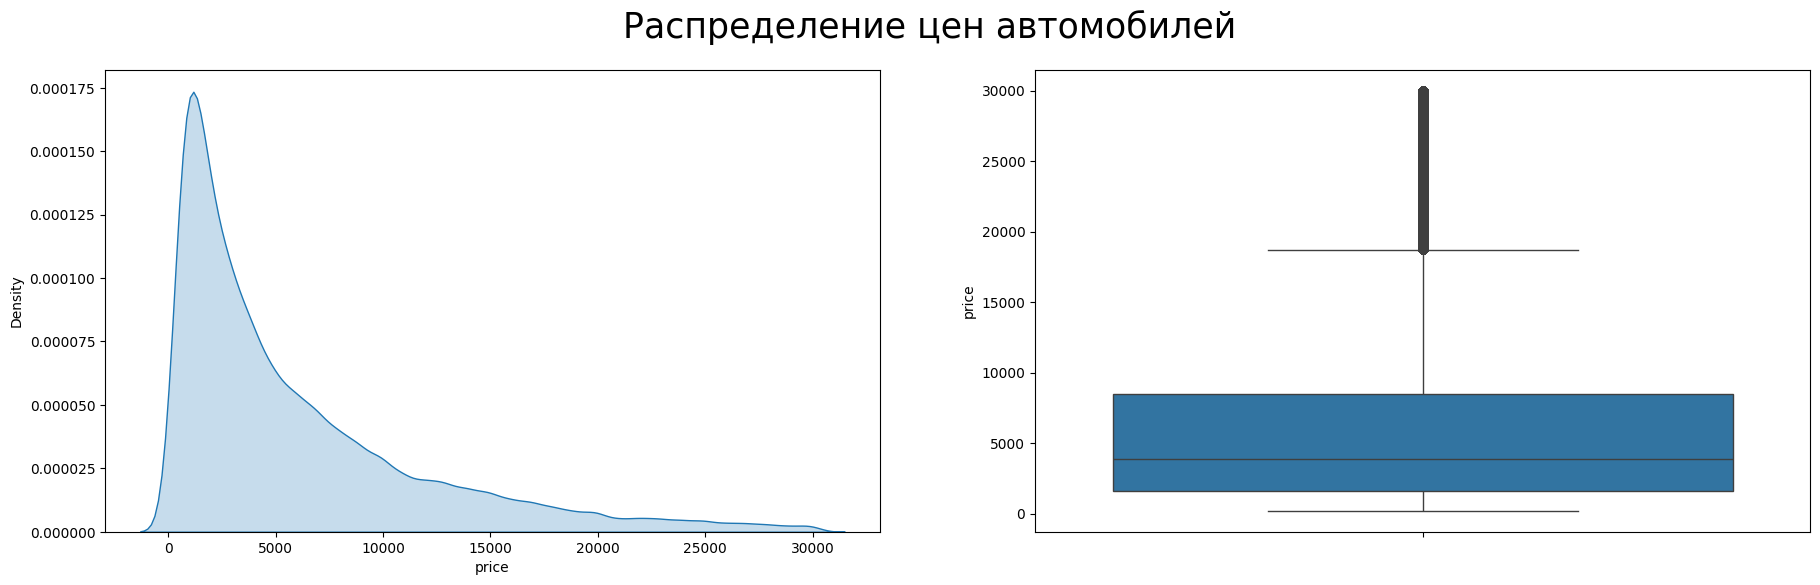

In [298]:
print(f'Медианная стоимость машин составила {int(df.price.median())} долларов')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 6))

plt.subplot(1, 2, 1)
ax = sns.kdeplot(df.price, shade=True)
# _ = ax.xaxis.set_major_formatter(fmtr)

plt.subplot(1, 2, 2)
ax = sns.boxplot(y=df.price)
# _ = ax.yaxis.set_major_formatter(fmtr)

fig.suptitle("Распределение цен автомобилей", fontsize=25)
plt.show()

На левом графике плотности (KDE) цены представлены в исходном масштабе и демонстрируют высокую плотность у нижней границы диапазона, что указывает на большое количество автомобилей с низкой стоимостью. На правом рисунке видно, что распределение имеет длинные хвосты с выбросами, и медиана смещена в сторону нижнего квартиля, подтверждая асимметричность распределения цен.

Простроим KDE график для прологарифмированных цен, позволяя наблюдать нормализованное распределение цен и упрощая восприятие асимметричных распределений с большими выбросами или длинными хвостами.

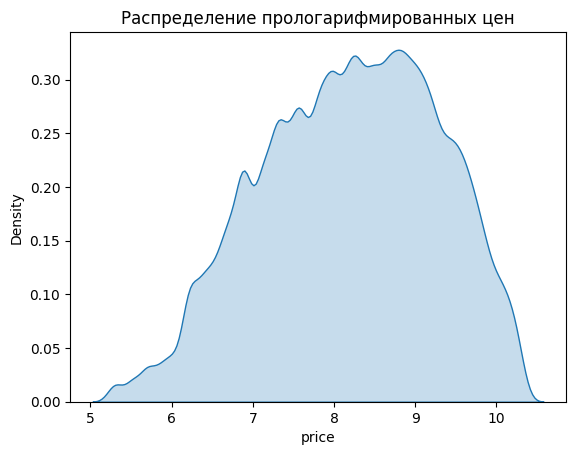

In [299]:
sns.kdeplot(np.log(df.price), shade=True)
plt.title('Распределение прологарифмированных цен')
plt.show()

Данный график иллюстрирует, что распределение цен после логарифмирования приближается к нормальному распределению. Это преобразование часто используется в статистическом анализе для стабилизации дисперсии и смягчения влияния выбросов.

Теперь для каждой категориальной переменной вычислим количество уникальных значений и выберем десять самых частых. Если среди наиболее частых значений встретится пустая строка, она будет исключена из рассмотрения.

Для каждой категориальной переменной построим гистограмму, показывающую распределение 10 наиболее часто встречающихся значений. Затем для каждой категориальной переменной строим диаграмму размаха, чтобы оценить, как распределение логарифмированных цен связано с каждой категорией, включая разброс и выбросы.



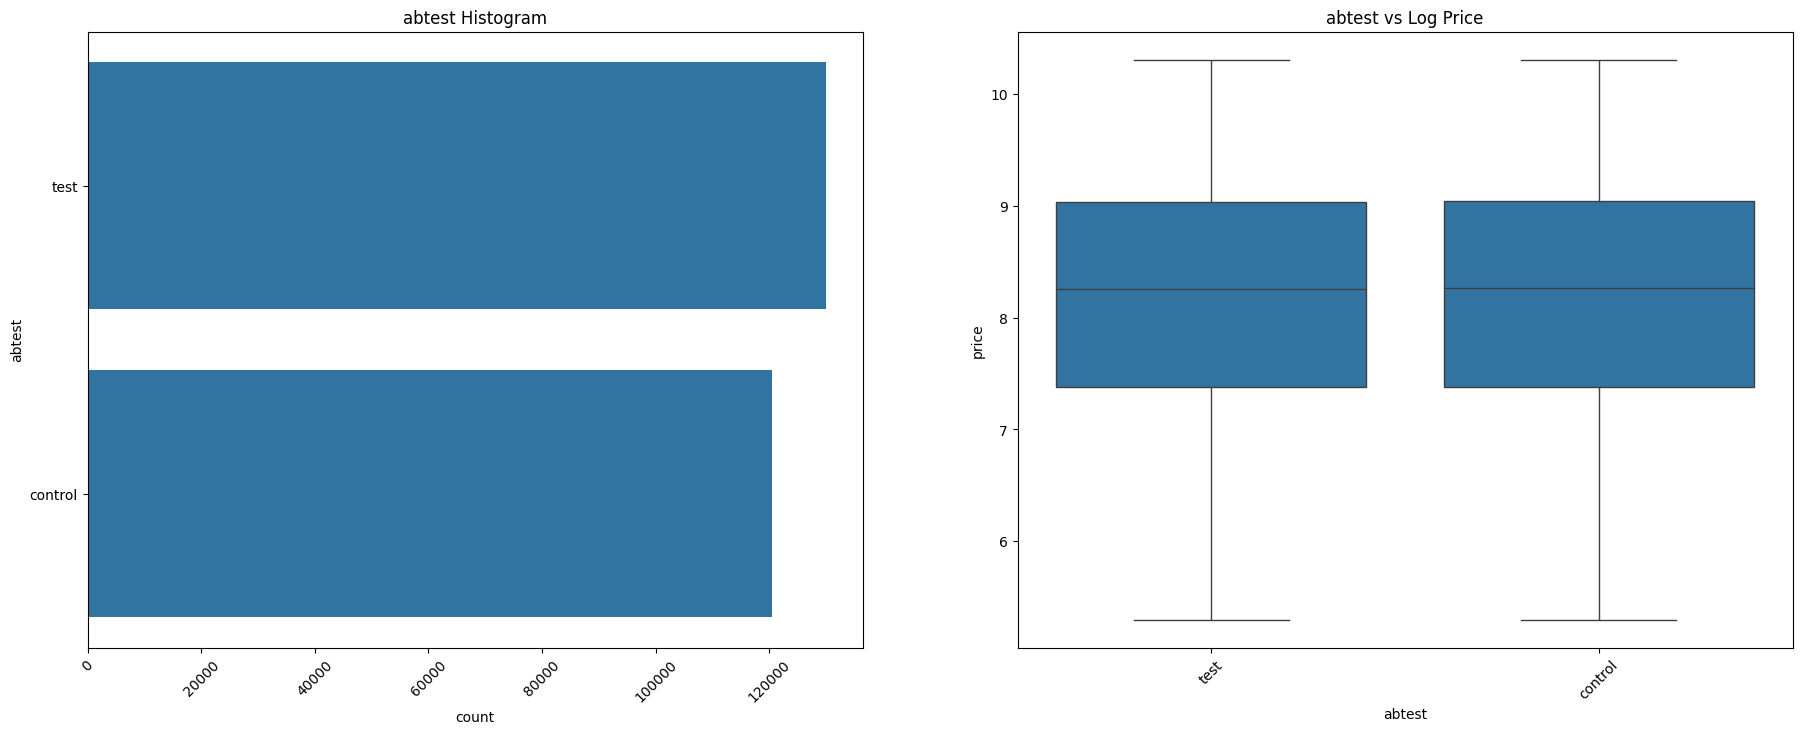

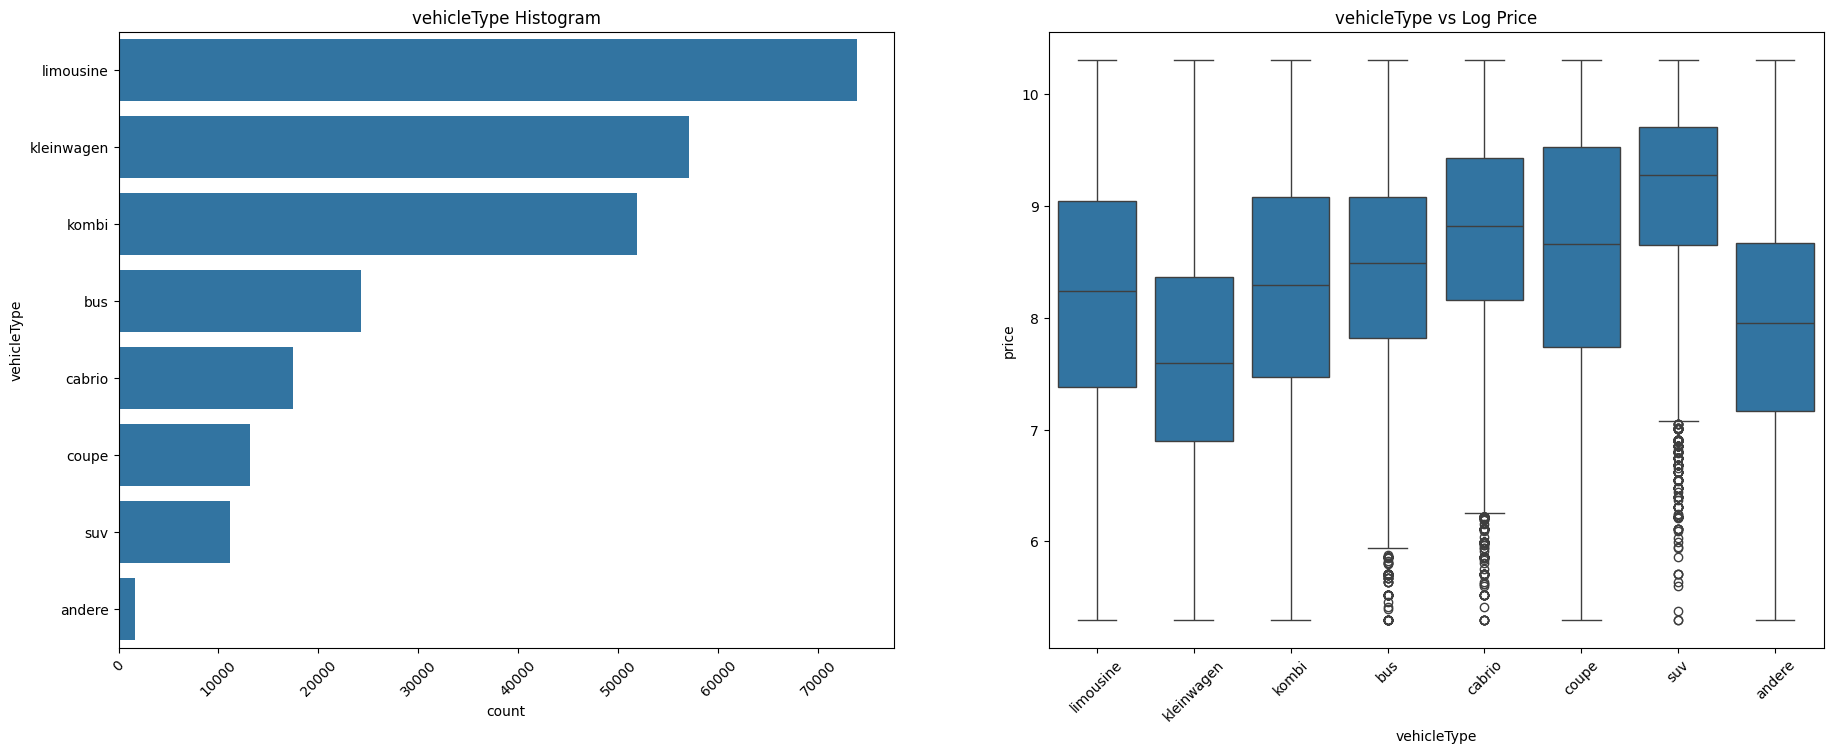

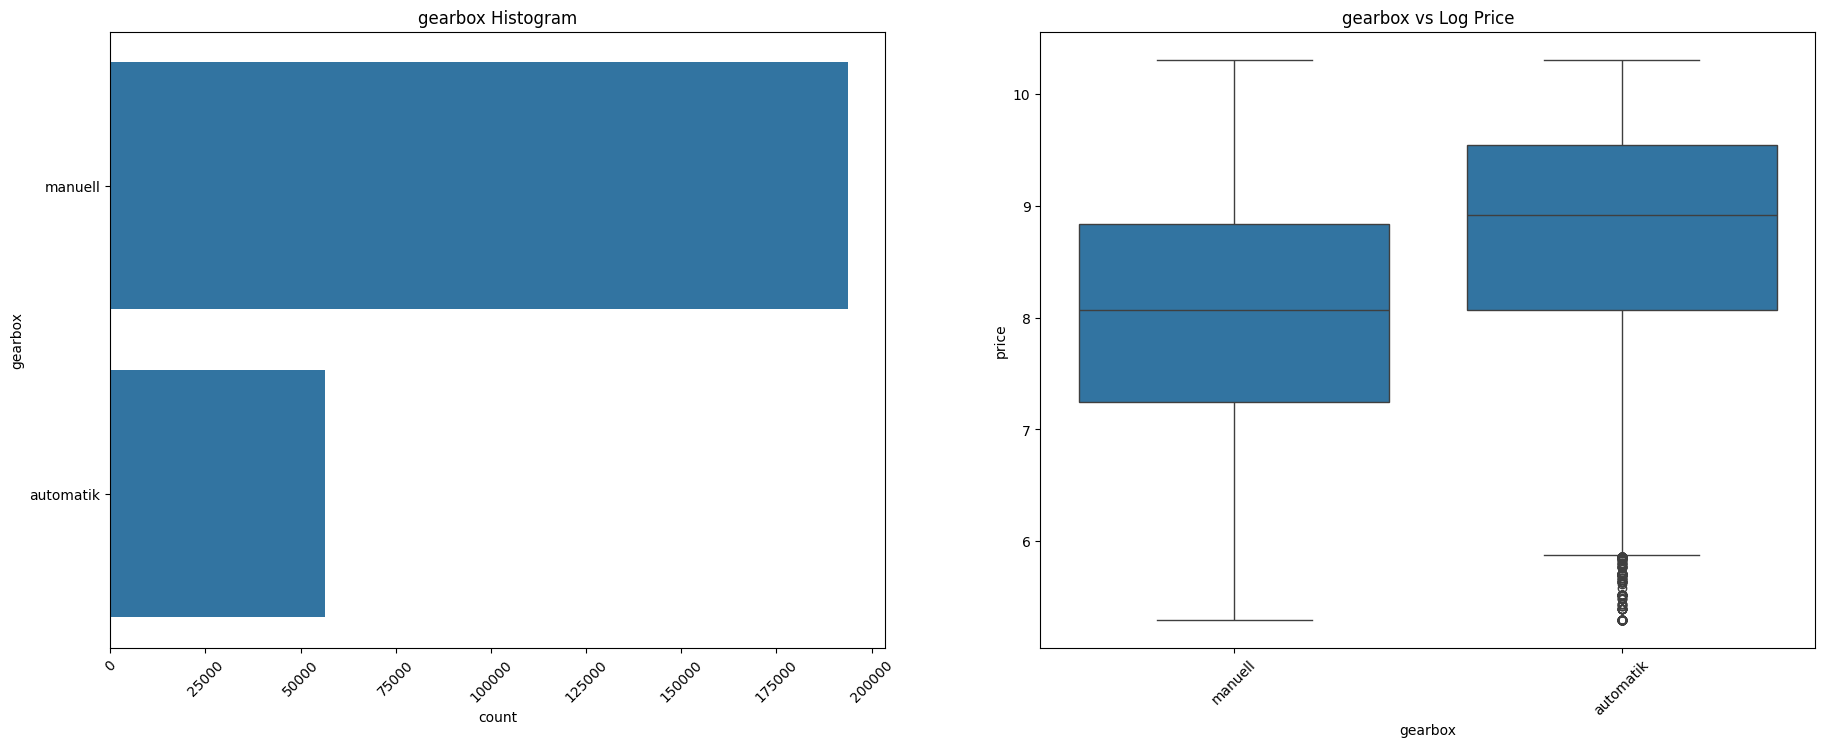

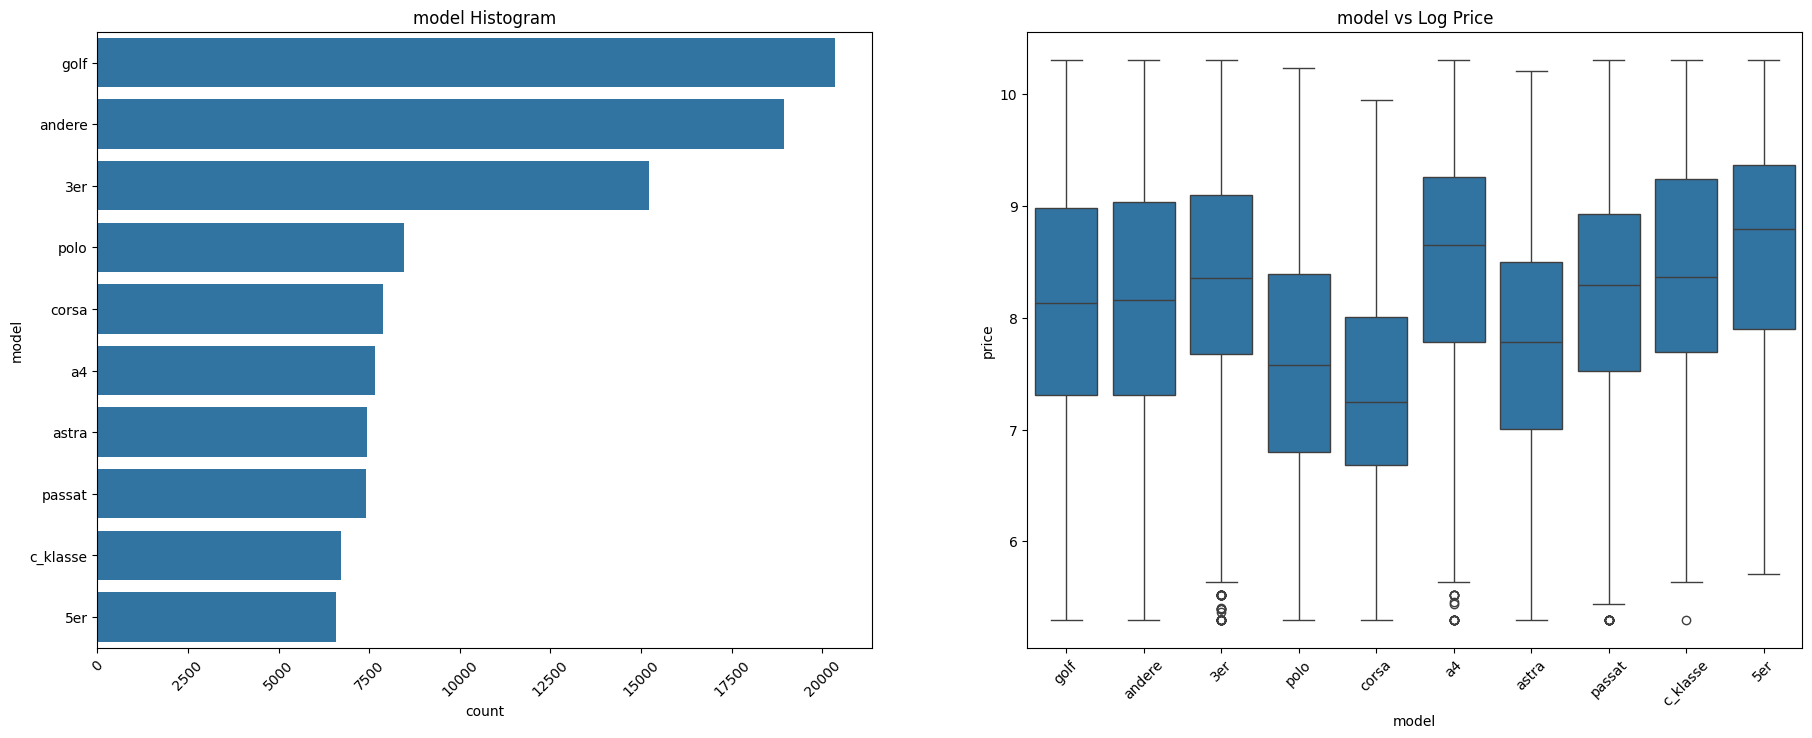

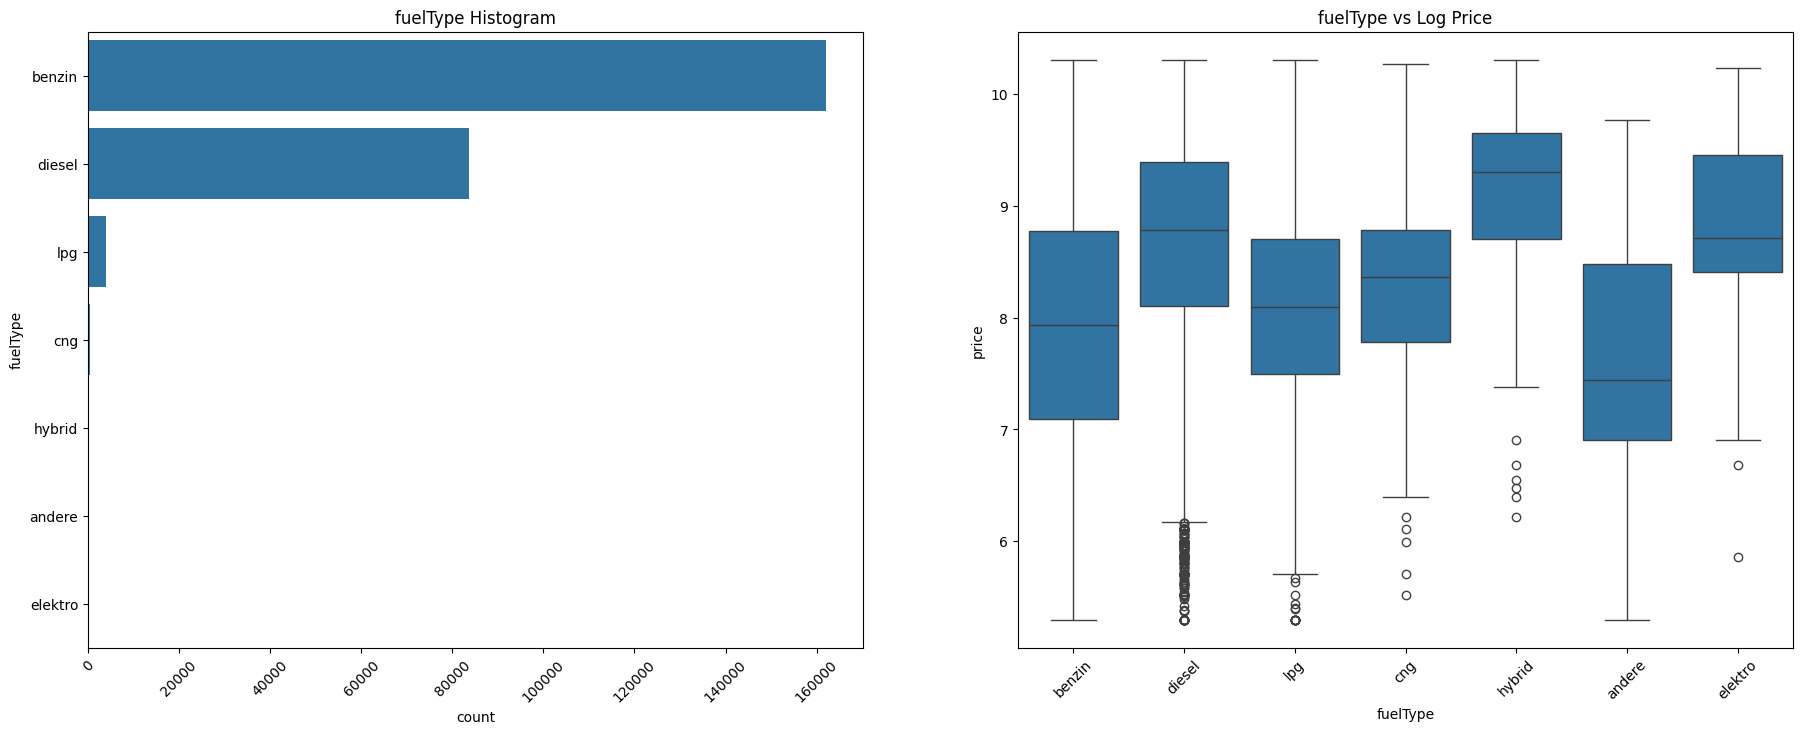

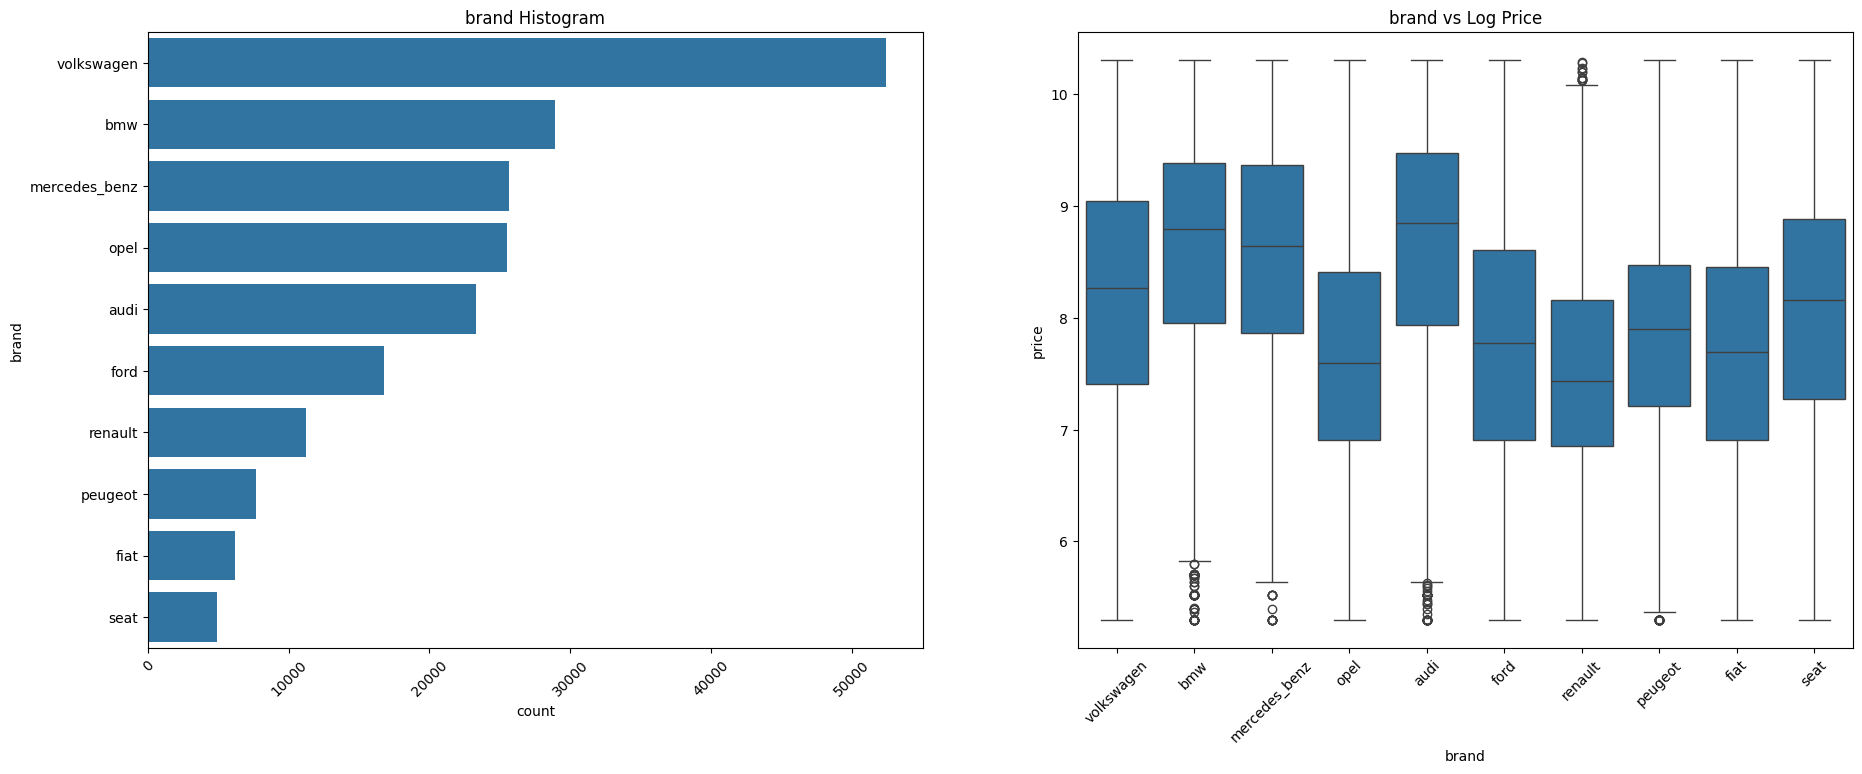

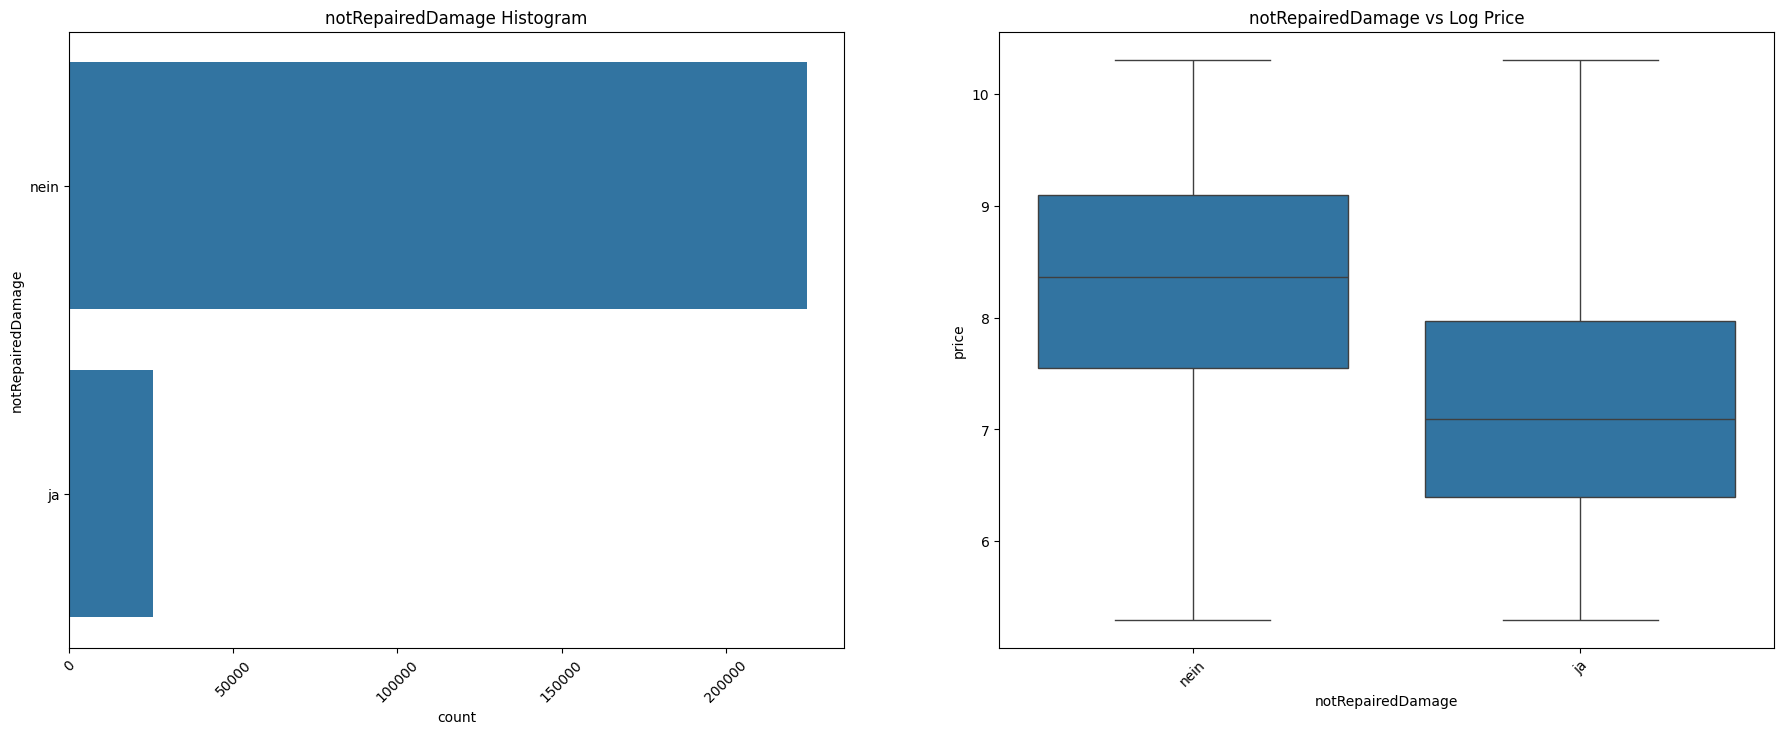

In [300]:
numbers_cols, categorical_cols = get_cols(df)

for column in categorical_cols:

    columne_most_freq = df[column].value_counts()[:10].sort_values(ascending=False).index

    if '' in columne_most_freq:
        columne_most_freq = columne_most_freq.drop('')

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))

    plt.subplot(1, 2, 1)
    plt.title(f'{column} Histogram')
    sns.countplot(
            df[df[column].isin(columne_most_freq)][column],
            order=columne_most_freq
            )
    plt.xticks(rotation=45)

    plt.subplot(1,2,2)
    plt.title(f'{column} vs Log Price')
    ax = sns.boxplot(
            x=df[df[column].isin(columne_most_freq)][column],
            y=np.log(df[df[column].isin(columne_most_freq)].price),
            order=columne_most_freq
            )
    plt.xticks(rotation=45)

    plt.show()

В совокупности эти диаграммы дают обширный взгляд на различные аспекты автомобильного рынка, используя данные о марках, моделях, цвете, типе топлива, коробке передач и других характеристиках автомобилей. Всё это дает комплексную картину рынка автомобилей, выделяя текущие тенденции и предпочтения потребителей, а также предоставляет важные данные для анализа и планирования бизнес-стратегий в автомобильной индустрии.

Количество числовых столбцов в данных:

In [221]:
len(numbers_cols)

4

Визуализируем взаимосвязи между различными числовыми характеристиками автомобилей и их ценой через ряд диаграмм рассеяния. Логарифмирование данных применяется для более ясного представления экспоненциальных отношений и уменьшения влияния выбросов, что поможет в анализе тенденций и выявлении закономерностей в данных.

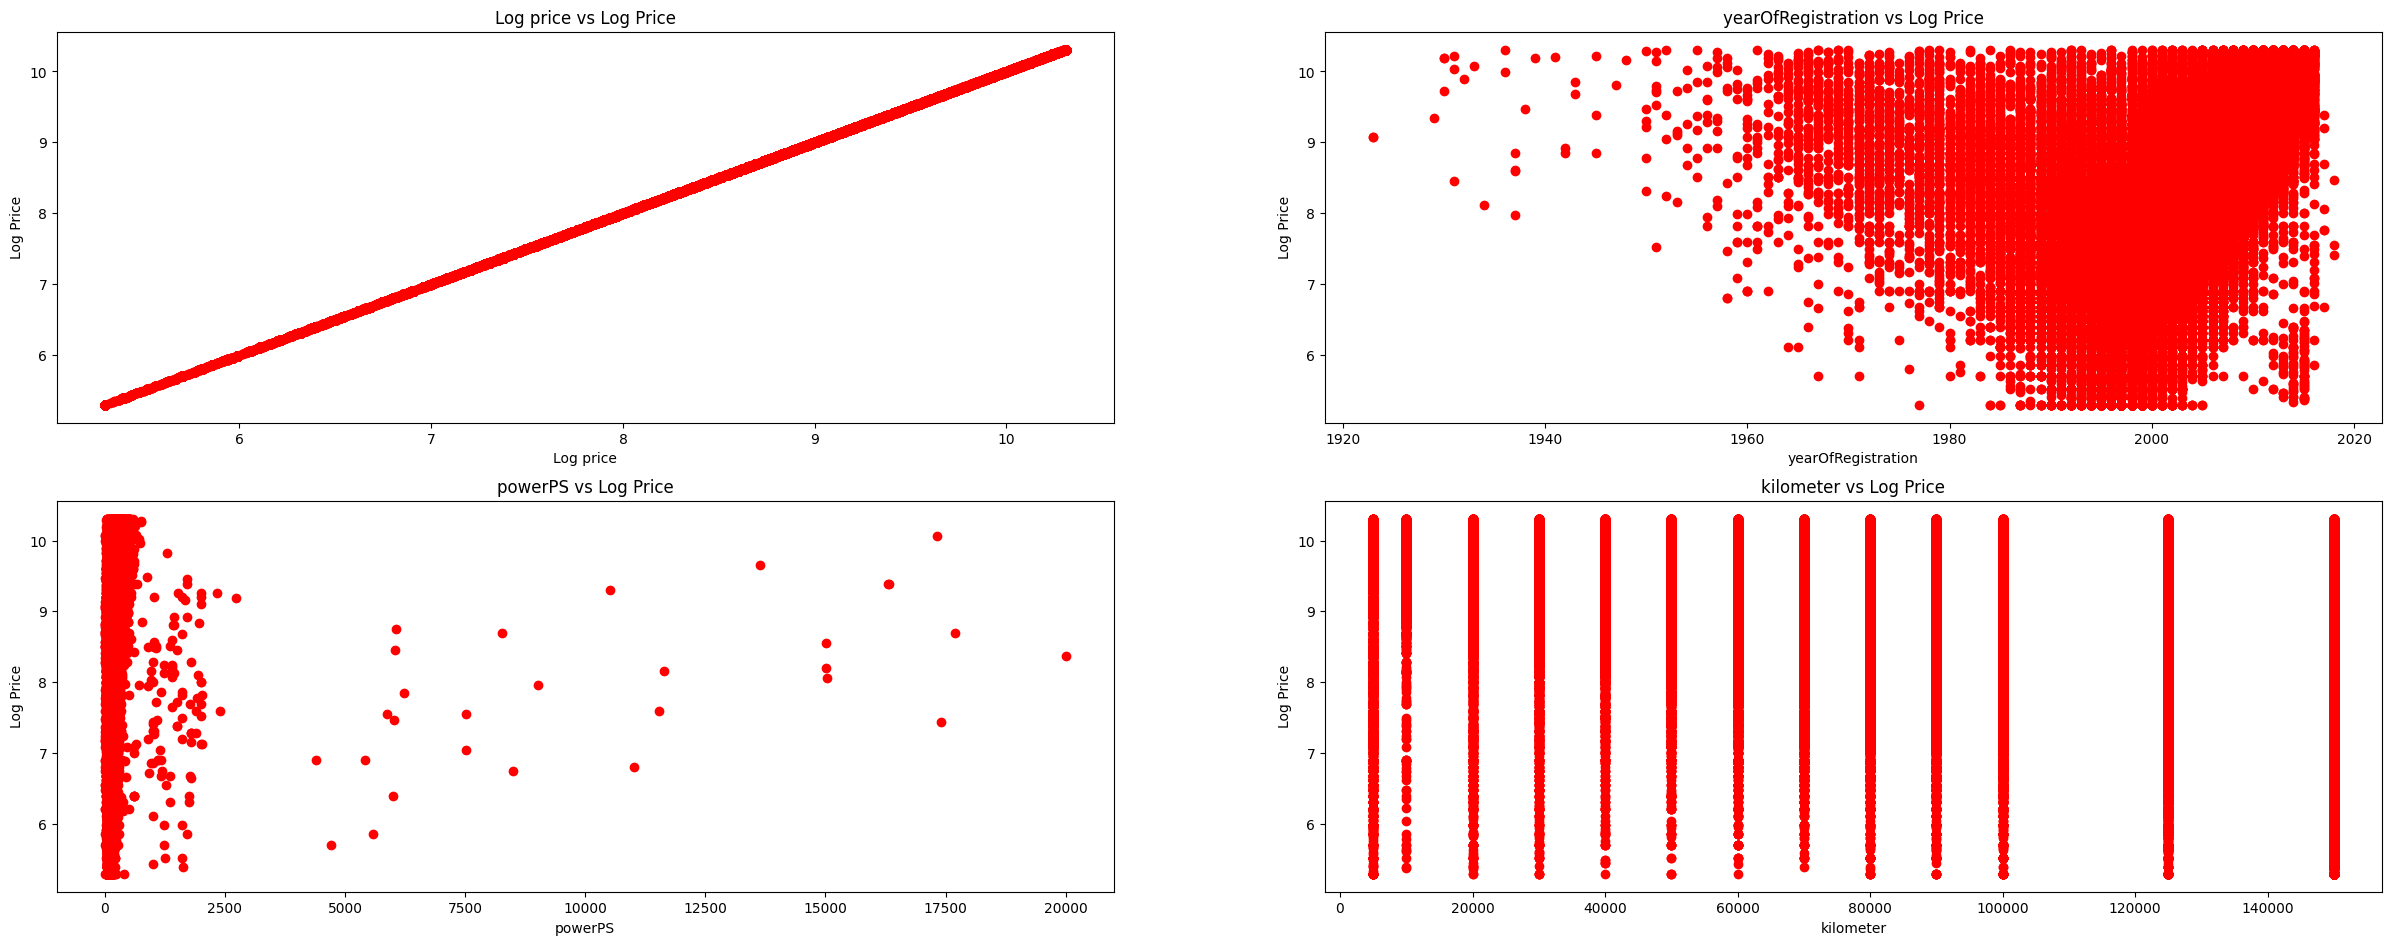

In [54]:
def scatter(column, fig):
    """
    Создает диаграмму рассеяния между указанной колонкой и логарифмом цены.
    """
    plt.subplot(33, 2, fig)
    ax = plt.scatter(
        x=[price if 'price' not in column else np.log(price) for price in df[df[column] > 0][column]],
        y=np.log(df[df[column] > 0].price),
        color='red'
        )
    plt.title(f'{column} vs Log Price', fontsize=40)
    plt.title(f'{column} vs Log Price' if 'price' not in column else f'Log {column} vs Log Price')
    plt.ylabel('Log Price')
    plt.xlabel(column if 'price' not in column else f'Log {column}')

plt.figure(figsize=(30, 200))

for i, column in enumerate(numbers_cols):
    scatter(column, i + 1)

###<font size=6 color='Teal'> Описательная статистика

Метод `describe()` предоставляет описательную статистику по всем числовым столбцам DataFrame. Это включает в себя такие показатели, как среднее значение, стандартное отклонение, минимальное и максимальное значения, а также квантили, включая медиану.

In [301]:
df.describe()

,price,yearOfRegistration,powerPS,kilometer
count,250335.000000,250335.000000,250335.000000,250335.000000
mean,6017.769030,2003.307648,124.031474,125117.981904
std,5996.338441,6.314167,140.134313,38762.133811
min,200.000000,1923.000000,0.000000,5000.000000
25%,1600.000000,1999.000000,80.000000,100000.000000
50%,3850.000000,2004.000000,116.000000,150000.000000
75%,8450.000000,2008.000000,150.000000,150000.000000
max,30000.000000,2018.000000,20000.000000,150000.000000


powerPS - Мощность двигателя в лошадинных силах (л. с.). Минимальное значение - 0. Если машина имеет такое аномальное значение, можно ли считать это машиной? Посмотрим статистику таких машин:

In [302]:
df[df['powerPS'] <= df['powerPS'].quantile(0.05)].describe()

,price,yearOfRegistration,powerPS,kilometer
count,14731.000000,14731.000000,14731.000000,14731.000000
mean,2719.146154,1998.505125,17.853914,128699.680945
std,3911.779565,8.211910,22.566768,37965.859345
min,200.000000,1923.000000,0.000000,5000.000000
25%,700.000000,1997.000000,0.000000,125000.000000
50%,1300.000000,1999.000000,0.000000,150000.000000
75%,2850.000000,2003.000000,45.000000,150000.000000
max,30000.000000,2018.000000,50.000000,150000.000000


In [303]:
df[df['powerPS'] >= 2500].describe()

,price,yearOfRegistration,powerPS,kilometer
count,30.000000,30.000000,30.000000,30.000000
mean,4898.800000,2003.000000,10275.866667,116166.666667
std,5301.908813,5.458306,4934.429427,48060.366734
min,300.000000,1993.000000,2729.000000,5000.000000
25%,1287.500000,1997.500000,6018.750000,98750.000000
50%,3020.000000,2004.000000,8753.500000,137500.000000
75%,5999.750000,2007.000000,15015.250000,150000.000000
max,23333.000000,2012.000000,20000.000000,150000.000000


Очень аноимальные данные, которые не отражают реальность. Лучше удалить их.

In [304]:
df = df[df['powerPS'] >= df['powerPS'].quantile(0.05)]
df = df[df['powerPS'] <= 2500]

Построим график, отображающий величину корреляции (без учёта знака, используется абсолютное значение) между ценой автомобилей и другими числовыми признаками в DataFrame.

Метод `corr()` используется для расчета корреляции между столбцами, а `sort_values(ascending = False)` сортирует значения корреляции по убыванию, исключая при этом цену (поскольку корреляция цены с самой собой будет равна 1).

Такой график может помочь выявить наиболее важные числовые признаки, которые потенциально оказывают наибольшее влияние на цену автомобиля.

Сначала отфильтруем исходный DataFrame, оставляя только числовые столбцы, затем вычислим корреляционную матрицу для этих столбцов, выберем столбец, соответствующий корреляции с ценой, исключим корреляцию цены с самой собой, преобразуем все значения корреляции в абсолютные значения, отсортируем их по убыванию и визуализируем результат на столбчатой диаграмме.

<Axes: >

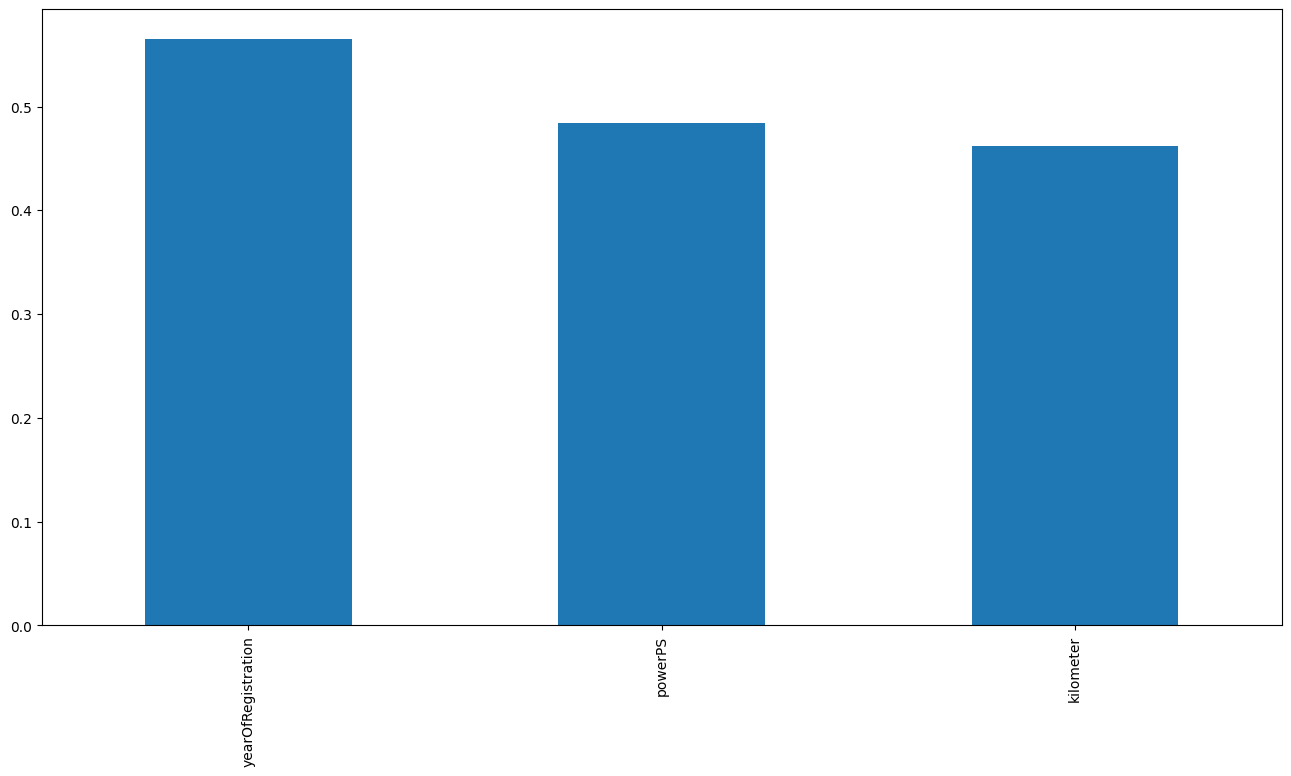

In [305]:
df.select_dtypes(include=[np.number]).corr()['price'].drop('price').abs().sort_values(ascending=False).plot(kind='bar', figsize=(16, 8))

На графике представлены абсолютные значения корреляций, что позволяет оценивать величину влияния без учёта направления связи.

Например, признак "yearOfRegistration" демонстрирует наивысшую степень ассоциации с ценой, что может свидетельствовать о значимости этого параметра в определении рыночной стоимости автомобиля. Другие признаки показывают меньшую, но всё же заметную связь с ценой, что может быть объяснено практической значимостью этих параметров для конечных потребителей.

Эти данные используются для создания предиктивных моделей стоимости автомобилей, где признаки с наивысшей корреляцией могут служить важными предикторами. Также они могут указывать на потребительские предпочтения на рынке автомобилей и служить в качестве основы для стратегического планирования производителями.

In [149]:
d = {}

for brand in df['brand'].unique():
  d[brand] = list(df[df['brand'] == brand]['model'].unique())

In [150]:
d

{'volkswagen': ['golf',
  'andere',
  'passat',
  'polo',
  'scirocco',
  'transporter',
  'jetta',
  nan,
  'eos',
  'touran',
  'lupo',
  'caddy',
  'tiguan',
  'sharan',
  'up',
  'fox',
  'beetle',
  'touareg',
  'kaefer',
  'phaeton',
  'cc',
  'bora',
  'amarok'],
 'audi': [nan,
  'a8',
  'a4',
  'a1',
  'tt',
  'a6',
  '80',
  '100',
  'a3',
  'a2',
  'a5',
  'andere',
  'q5',
  '90',
  'q3',
  'q7',
  '200'],
 'jeep': ['grand', 'wrangler', 'cherokee', 'andere', nan],
 'skoda': ['fabia',
  'yeti',
  'octavia',
  'roomster',
  'andere',
  nan,
  'superb',
  'citigo'],
 'bmw': ['3er',
  '5er',
  '1er',
  'andere',
  '7er',
  'z_reihe',
  nan,
  '6er',
  'x_reihe',
  'm_reihe',
  'i3'],
 'peugeot': ['2_reihe',
  '3_reihe',
  nan,
  'andere',
  '4_reihe',
  '1_reihe',
  '5_reihe'],
 'ford': ['c_max',
  'ka',
  'fiesta',
  'escort',
  'focus',
  'mustang',
  'mondeo',
  's_max',
  'galaxy',
  'andere',
  'transit',
  'kuga',
  nan,
  'fusion',
  'b_max'],
 'mazda': ['3_reihe',
  'and

In [151]:

df[df['brand'] == 'volkswagen']['model'].unique()

array(['golf', 'andere', 'passat', 'polo', 'scirocco', 'transporter',
       'jetta', nan, 'eos', 'touran', 'lupo', 'caddy', 'tiguan', 'sharan',
       'up', 'fox', 'beetle', 'touareg', 'kaefer', 'phaeton', 'cc',
       'bora', 'amarok'], dtype=object)

###<font size=6 color='Teal'> Преобразование категореальных переменных

Категория A/B-тестирования. Не может быть конечным признаком для машин, это скорее информация для исследователя, от какой группы данное наблюдение - контрольной или тестовой

In [306]:
df.drop(['abtest'], axis=1, inplace=True)

In [307]:
df.dtypes

price                 float64
vehicleType            object
yearOfRegistration      int64
gearbox                object
powerPS               float64
model                  object
kilometer             float64
fuelType               object
brand                  object
notRepairedDamage      object
dtype: object

In [308]:
df['gearbox'].value_counts()

gearbox
manuell      184283
automatik     54123
Name: count, dtype: int64

#### notRepairedDamage

In [230]:
notRepairedDamage_le = LabelEncoder().fit(df['notRepairedDamage'])
notRepairedDamage_labeled_df = pd.DataFrame(notRepairedDamage_le.transform(df['notRepairedDamage']), columns=['notRepairedDamage'], index=df.index)
notRepairedDamage_labeled_df.head()

,notRepairedDamage
3,1
4,1
5,0
6,1
10,1


#### gearbox

In [231]:
gearbox_le = LabelEncoder().fit(df['gearbox'])
gearbox_labeled_df = pd.DataFrame(gearbox_le.transform(df['gearbox']), columns=['gearbox'], index=df.index)
gearbox_labeled_df.head()

,gearbox
3,1
4,1
5,1
6,1
10,1


#### vehicleType, fuelType - One hot encoding

In [232]:
df.vehicleType.unique()

array(['kleinwagen', 'limousine', 'cabrio', 'kombi', 'suv', 'bus',
       'coupe', 'andere'], dtype=object)

In [233]:
vehicleType_one_hot_df = pd.get_dummies(df['vehicleType'], dtype=int)
vehicleType_one_hot_df.head()

,andere,bus,cabrio,coupe,kleinwagen,kombi,limousine,suv
3,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,1,0
6,0,0,1,0,0,0,0,0
10,0,0,0,0,0,0,1,0


In [234]:
df.fuelType.unique()

array(['benzin', 'diesel', 'lpg', 'andere', 'hybrid', 'cng', 'elektro'],
      dtype=object)

In [235]:
fuelType_one_hot_df = pd.get_dummies(df['fuelType'], dtype=int)
fuelType_one_hot_df.head()

,andere,benzin,cng,diesel,elektro,hybrid,lpg
3,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0
5,0,1,0,0,0,0,0
6,0,1,0,0,0,0,0
10,0,1,0,0,0,0,0


#### model, brand - Binary Encoding

In [236]:
from category_encoders.binary import BinaryEncoder

#Binary encode
model_be = BinaryEncoder().fit(df['model'])
model_bin_df = model_be.transform(df['model'])
model_bin_df.head()

,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7
3,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,1,1
6,0,0,0,0,0,1,0,0
10,0,0,0,0,0,1,0,1


In [237]:
brand_be = BinaryEncoder().fit(df['brand'])
brand_bin_df = brand_be.transform(df['brand'])
brand_bin_df.head()

,brand_0,brand_1,brand_2,brand_3,brand_4,brand_5
3,0,0,0,0,0,1
4,0,0,0,0,1,0
5,0,0,0,0,1,1
6,0,0,0,1,0,0
10,0,0,0,1,0,1


In [238]:
df.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
3,1500.000000,kleinwagen,2001,manuell,75.000000,golf,150000.000000,benzin,volkswagen,nein
4,3600.000000,kleinwagen,2008,manuell,69.000000,fabia,90000.000000,diesel,skoda,nein
5,650.000000,limousine,1995,manuell,102.000000,3er,150000.000000,benzin,bmw,ja
6,2200.000000,cabrio,2004,manuell,109.000000,2_reihe,150000.000000,benzin,peugeot,nein
10,2000.000000,limousine,2004,manuell,105.000000,3_reihe,150000.000000,benzin,mazda,nein


In [239]:
df_encoded = pd.concat([
    notRepairedDamage_labeled_df,
    gearbox_labeled_df,
    vehicleType_one_hot_df,
    fuelType_one_hot_df,
    model_bin_df,
    brand_bin_df,
    df[['yearOfRegistration', 'powerPS', 'kilometer', 'price']]
    ], axis=1)

In [240]:
df_encoded.shape

(238406, 35)

In [241]:
df.isna().sum()

price                 0
vehicleType           0
yearOfRegistration    0
gearbox               0
powerPS               0
model                 0
kilometer             0
fuelType              0
brand                 0
notRepairedDamage     0
dtype: int64

In [242]:
print("Количество признаков:", df_encoded.shape[1])

Количество признаков: 35


In [243]:
df_encoded.dtypes

notRepairedDamage       int64
gearbox                 int64
andere                  int64
bus                     int64
cabrio                  int64
coupe                   int64
kleinwagen              int64
kombi                   int64
limousine               int64
suv                     int64
andere                  int64
benzin                  int64
cng                     int64
diesel                  int64
elektro                 int64
hybrid                  int64
lpg                     int64
model_0                 int64
model_1                 int64
model_2                 int64
model_3                 int64
model_4                 int64
model_5                 int64
model_6                 int64
model_7                 int64
brand_0                 int64
brand_1                 int64
brand_2                 int64
brand_3                 int64
brand_4                 int64
brand_5                 int64
yearOfRegistration      int64
powerPS               float64
kilometer 

In [244]:
df = df_encoded

In [245]:
df.isna().sum().sum()

0

###<font size=6 color='Teal'> Модель OLS

Модель OLS (Ordinary Least Squares, Обыкновенные Наименьшие Квадраты) — это метод в статистике, используемый для оценки параметров в линейной регрессионной модели. Модель OLS стремится минимизировать сумму квадратов разностей между наблюдаемыми значениями зависимой переменной и значениями, предсказанными моделью регрессии.

Другими словами, метод находит линию (или гиперплоскость в случае множественных переменных), которая наилучшим образом соответствует набору точек данных, минимизируя суммарное расстояние от каждой точки данных до линии. Это делается путём оптимизации коэффициентов (весов) перед независимыми переменными, чтобы сделать сумму квадратов этих расстояний как можно меньше.

Модель OLS широко используется из-за своей простоты и свойств эффективности в случае выполнения определённых условий (например, отсутствия мультиколлинеарности, нормальности распределения ошибок и др.). Когда данные соответствуют предположениям линейной регрессии, OLS дает несмещенные, состоятельные и эффективные оценки параметров модели.

Подготовим данные для построения модели линейной регрессии. Сначала из набора данных извлечем числовые и категориальные столбцы с помощью функции `get_cols()`. Категориальные столбцы преобразуем в числовые коды с использованием `LabelEncoder`, что позволит включить эти категориальные данные в модель в виде чисел.

Из данных удалим целевую переменную `Цена`, а для оставшихся признаков построим модель линейной регрессии с помощью библиотеки `statsmodels`, при этом цены логарифмируем для нормализации распределения. Включение константы в модель позволяет ей более точно оценить влияние независимых переменных на зависимую переменную.

Результаты должны показать, какие характеристики автомобиля наиболее сильно связаны с его ценой, что может быть полезно для ценообразования, оценки стоимости и понимания важных факторов, влияющих на стоимость автомобилей на рынке.

In [325]:
def encode_categorial(name_scaler, scaler, data, y=None, return_scaler=False):
    """
    Кодирует категориальные колонки в датасете с использованием указанного кодировщика.
    """
    if name_scaler != 'TargetEncoder':
        if not return_scaler:
            return data[categorical_cols].apply(lambda x: scaler.fit_transform(x.astype(str)))
        else:
            return data[categorical_cols].apply(lambda x: scaler.fit_transform(x.astype(str))), scaler
    else:
        if not return_scaler:
            return scaler.fit_transform(data[categorical_cols], y)
        else:
            return scaler.fit_transform(data[categorical_cols], y), scaler

def encode_number(name_scaler, scaler, data, return_scaler=False):
    """
    Применяет указанный кодировщик к числовым колонкам в датасете.
    """
    if name_scaler == 'Not scaled':
        if not return_scaler:
            return data
        else:
            return data, scaler
    else:
        if not return_scaler:
            return scaler.fit_transform(data)
        else:
            return scaler.fit_transform(data), scaler


numbers_cols, categorical_cols = get_cols(df.drop(['price'], axis=1))

data = df.copy()
data[categorical_cols], scaler_categorial = encode_categorial(
    'TargetEncoder',
    TargetEncoder(),
    data[categorical_cols],
    y,
    return_scaler=True
    )

data[numbers_cols], scaler_number = encode_number(
    'StandardScaler',
    StandardScaler(),
    data[numbers_cols],
    return_scaler=True
    )

X = data.drop(['price'], axis=1)
y = data['price']


X = data.drop(['price'], axis=1).values
y = np.log(df['price']).values

X = sm.add_constant(X)

res = sm.OLS(y, X)
res = res.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                 6.891e+04
Date:                Wed, 22 May 2024   Prob (F-statistic):               0.00
Time:                        18:04:38   Log-Likelihood:            -2.0079e+05
No. Observations:              238406   AIC:                         4.016e+05
Df Residuals:                  238396   BIC:                         4.017e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7074      0.061   -142.486      0.0

Сводка модели OLS представляет подробный анализ регрессионной модели, который позволяет оценить вклад каждого предиктора (независимой переменной) в предсказание зависимой переменной. Ключевые метрики и их значение:

- `R-squared` (коэффициент детерминации) — мера качества подгонки модели, показывает долю вариации зависимой переменной, которая объясняется моделью. Значение `0.652` указывает на то, что модель объясняет 65.2% вариации цены, что является довольно средним (можно сказать не очень хорошим) результатом.

- `Adj. R-squared` (скорректированный коэффициент детерминации) — аналогичен R-squared, но учитывает количество предикторов в модели и количество наблюдений. Это более строгая мера, которая наказывает за добавление незначимых переменных в модель. Значение 0.652 говорит о том, что после корректировки на количество переменных модель по-прежнему объясняет большую часть вариации цены.

- `F-statistic и Prob (F-statistic)` — тест на общую значимость модели. Значение F-статистики и её p-value позволяют протестировать нулевую гипотезу о том, что все коэффициенты регрессии в совокупности равны нулю. P-value менее 0.05 указывает на то, что модель в целом статистически значима.

- Коэффициенты (`coef`) — оценки параметров регрессии для каждого предиктора, показывают величину изменения зависимой переменной при изменении предиктора на одну единицу.

- `Std err` (стандартная ошибка коэффициентов) — показывает оценку стандартного отклонения коэффициента, что дает представление о точности оценок коэффициентов.

- `t` и `P>|t|` (t-статистика и p-value) — для каждого коэффициента показывают, насколько статистически значимым является его вклад. Если p-value меньше 0.05, предиктор считается значимым.

- `[0.025 0.975]` — 95% доверительный интервал для коэффициентов, показывает, в каких пределах с 95% уверенностью находятся оценки параметров.

- `Omnibus, Prob(Omnibus)` — тест на нормальность остатков. P-value меньше 0.05 указывает на то, что остатки не распределены нормально.

- `Skew` (коэффициент асимметрии) — мера асимметрии распределения остатков. Значение близкое к нулю говорит о симметричности распределения.

- `Kurtosis` (коэффициент эксцесса) — мера остроты пика распределения остатков. Значение больше 3 указывает на более острый пик, чем у нормального распределения.

- `Durbin-Watson` — тест на автокорреляцию остатков. Значения близкие к 2.0 указывают на отсутствие автокорреляции.

- `Jarque-Bera (JB)`и `Prob(JB)` — еще один тест на нормальность распределения остатков.

- `Cond. No.` (число обусловленности) — мера чувствительности функции к изменениям входных данных. Большое значение может указывать на проблемы мультиколлинеарности, когда два или более предикторов сильно коррелированы и, следовательно, могут быть линейно зависимы.

Эти метрики необходимы для оценки точности, надежности и предсказательной способности регрессионной модели. Их анализ помогает понять, насколько хорошо модель работает и какие переменные оказывают наибольшее влияние на зависимую переменную. Это основа для принятия обоснованных решений при построении предиктивных моделей и их использовании в практических задачах.

Исходя из сводки модели OLS, можно сделать следующие выводы:

1. *Модель хорошо подходит для данных:* `R-squared` близок к `1`, что указывает на то, что модель объясняет большую часть вариации цены автомобилей.

2. *Модель в целом статистически значима:* `F-статистика` достаточно высока, и соответствующее `p-value` стремится к нулю.

3. *Большинство предикторов являются статистически значимыми:* у многих переменных (`x`) `p-value` меньше `0.05`, что говорит о значимом влиянии на зависимую переменную — цену автомобилей.

4. *Проблемы с распределением остатков:* тесты `Omnibus` и `Jarque-Bera` отклоняют нулевую гипотезу о нормальности остатков, что может указывать на некоторые проблемы с моделью, например, на наличие выбросов или неправильную спецификацию модели.

5. *Нет значительной автокорреляции:* значение `Durbin-Watson` близко к `2`, что указывает на отсутствие автокорреляции остатков.

6. *Возможная мультиколлинеарность:* большое число обусловленности (`Cond. No`.) предполагает, что между некоторыми предикторами существует мультиколлинеарность, что может влиять на надежность коэффициентов.

Несмотря на хороший `R-squared`, проблемы с нормальностью остатков и мультиколлинеарностью могут означать, что предположения линейной регрессии нарушены, и следует проявлять осторожность при интерпретации результатов. Требуется дополнительное исследование данных, исключение или преобразование некоторых переменных или использование других типов моделей для улучшения качества предсказаний.

Следующие шаги представляют собой процесс пост-анализа линейной регрессионной модели, который включает в себя оценку точности предсказаний, проверку значимости признаков и визуализацию результатов.

Функция `find_prediction_at_instance_for_ols()` предназначена для вычисления предсказанного значения цены автомобиля на основе параметров OLS модели и входных данных для конкретного наблюдения (экземпляра).

In [326]:
def find_prediction_at_instance_for_ols(X, params, instance):
    """
    Вычисляет предсказание модели OLS для указанного наблюдения.
    """
    return sum([val*X[instance, i].sum() for i, val in enumerate(params[:-1])])

Строим график, который сравнивает фактические значения цен (в логарифмическом масштабе) с предсказанными моделью OLS. На графике также отображается красная линия y=x для визуального сравнения точности предсказаний.

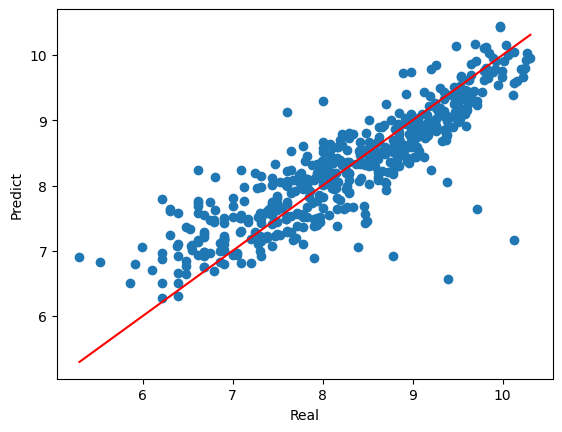

In [327]:
plt.plot([y.min(), y.max()], [y.min(), y.max()],  c='r')
plt.scatter(y[:500], res.predict(X[:500]))

plt.xlabel('Real')
plt.ylabel('Predict')

plt.show()

На рисунке красная линия представляет идеальное соответствие между фактическими и предсказанными значениями, то есть линию, где предсказанные цены равны фактическим. Если бы все точки были расположены вдоль этой линии, это указывало бы на идеальную точность предсказаний.

Точки, распределенные вокруг линии, показывают реальные предсказания модели. Чем ближе точки к красной линии, тем более точным является предсказание модели. Распределение точек также дает представление о вариативности и возможных закономерностях ошибок предсказания. На диаграмме можно видеть, что хотя многие предсказания близки к фактическим значениям (похоже на плотное облако вокруг линии идентичности), есть и значительное количество точек, которые отклоняются от красной линии, указывая на ошибки предсказания модели.

Можно сделать вывод, что модель обладает некоторой предсказательной способностью, но при этом имеются ошибки предсказания.

Метод `.predict()` возвращает массив предсказанных значений логарифма цены для каждого наблюдения в наборе данных на основе оцененных параметров модели.

In [328]:
res.predict(X)

array([ 7.4325754 ,  8.69396559,  6.84649712, ...,  8.09026825,
        7.91006615, 10.59742385])

Данные значения являются логарифмированными прогнозами цен автомобилей. Чтобы получить предсказания в исходном масштабе цен, необходимо применить обратное преобразование логарифма, то есть экспоненцирование этих значений. Эти значения могут использоваться для оценки качества модели, сравнения с фактическими ценами или для внутреннего анализа, например, для выявления, насколько хорошо модель работает на различных уровнях цен.

Теперь вычислим коэффициент детерминации $R^2$, чтобы оценить качество подгонки модели. Более высокий $R^2$ указывает на лучшее соответствие модели данным.

In [329]:
r2_score(y, res.predict(X))

0.7223306207712255

Используем метод `.rsquared_adj` из статистического вывода модели OLS:

In [330]:
print(f'R^2: {res.rsquared_adj}')

R^2: 0.7223201381103878


Продолжим анализ результатов регрессии. Создадим список названий столбцов из исходного DataFrame, за исключением столбца `'Цена'`, поскольку он является зависимой переменной модели.

In [331]:
cols = df.columns.to_list()
cols.remove('price')

Затем устанавим формат отображения числовых значений в DataFrame для более удобного восприятия — числа будут выводиться с шестью знаками после запятой.

In [332]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)

Создадим DataFrame с названиями и коэффициентами признаков, включая `intercept`, который представляет собой свободный член модели, отражающий начальное значение зависимой переменной при нулевых значениях независимых переменных. Этот DataFrame также будет содержать p-значения для каждого коэффициента, помогающие оценить их статистическую значимость. Затем отсортируем его по абсолютным значениям коэффициентов, что позволит определить, какие признаки наиболее важны для предсказания цены, при этом более низкое p-значение указывает на большую значимость признака.

In [333]:
cols = ['intercept'] + cols

ols = pd.DataFrame()
ols['feature'] = cols
ols['coefs'] = abs(res.params)
ols['p_value'] = res.pvalues
ols = ols.sort_values(by='coefs')

print(ols)

              feature    coefs  p_value
3             gearbox 0.140336 0.000000
4             powerPS 0.228363 0.000000
6           kilometer 0.274720 0.000000
5               model 0.294463 0.000000
8               brand 0.323427 0.000000
1         vehicleType 0.333050 0.000000
7            fuelType 0.350946 0.000000
2  yearOfRegistration 0.406730 0.000000
9   notRepairedDamage 0.615635 0.000000
0           intercept 8.707446 0.000000


Результаты коэффициентов регрессии и их p-значений показывают, что:

- Переменные с наименьшими коэффициентами (например, `Пробег`, `Объем_багажника_min`, `model`) оказывают наименьшее влияние на целевую переменную, что может указывать на их меньшую важность в модели.

- Переменные с p-значением меньше 0.05 (например, `mark`, `car_type`, `Привод`) считаются статистически значимыми, что указывает на их существенное влияние на зависимую переменную.

- Самые высокие коэффициенты у переменных `Топливо`, `Марка_топлива`, и `intercept`. Это подчеркивает их сильное влияние на цену. Особенно большой коэффициент у `intercept`, что может быть связано с начальным уровнем цены.

- Некоторые переменные (например, `Диаметр_цилиндра_и_ход_поршня` и `model`) имеют высокие p-значения, что может указывать на их незначительную роль в предсказании цены или на наличие избыточности данных.

- Присутствует переменная `Объем_багажника_min` с низким коэффициентом и p-значением, что может означать, что она имеет меньшее влияние на цену, но это влияние все же статистически значимо.

- Наконец, значительное количество переменных имеют очень маленькие коэффициенты с p-значениями, близкими к нулю, что подтверждает их статистическую значимость в модели.

Наибольшее влияние на цену оказывают тип топлива, марка топлива и базовый уровень цены (`intercept`), в то время как некоторые другие характеристики не показывают значимого влияния на цену в данной модели.

Проведем оценку точности предсказательной модели. Создадим копию исходного набора данных и извлечем переменные `X` (независимые переменные, без цены) и `y` (целевая переменная, цена).

In [334]:
X = data.drop(['price'], axis = 1)
y = np.log(data.price)

К независимым переменным `X` добавим столбец константы. Это делается для учета свободного члена (`intercept`) в модели линейной регрессии, представлящий собой начальное значение целевой переменной `y` при всех нулевых значениях независимых переменных.

С использованием обновленных данных `X_with_const`, содержащих константу, создадим объект `prediction`, куда занесем предсказанные значения цен. Предсказания будут получены путем применения обученной модели регрессии (`res`) к независимым переменным с константой и преобразования полученных логарифмических значений обратно в исходный масштаб с помощью экспоненциации. Cохраним фактические значения цен и рассчитаем абсолютную ошибку между предсказанными и фактическими ценами.

In [335]:
X_with_const = sm.add_constant(X)

prediction = pd.DataFrame()
prediction['pred'] = res.predict(X_with_const)
prediction['fact'] = y
prediction['abs'] = abs(prediction['fact'] - prediction['pred'])

Полученный набор данных `prediction` транспонируем для лучшего отображения данных и анализа. Это позволит сравнить фактические и предсказанные значения, а также величину ошибок предсказания по каждому наблюдению.

In [336]:
prediction.T

,3,4,5,6,10,11,14,17,18,19,...,371806,371807,371808,371809,371812,371813,371816,371820,371821,371823
pred,7.432575,8.693966,6.846497,7.920756,7.744714,7.757224,10.104062,7.227006,8.578718,8.056149,...,8.608485,7.915681,8.364625,8.592559,6.868447,8.708544,7.840206,8.090268,7.910066,10.597424
fact,7.313220,8.188689,6.476972,7.696213,7.600902,7.937017,9.798071,7.467371,8.929303,7.522941,...,8.779557,7.600402,8.517193,8.389360,7.306531,8.974618,8.070906,7.089243,9.126959,10.274706
abs,0.119355,0.505276,0.369525,0.224544,0.143812,0.179794,0.305991,0.240365,0.350584,0.533208,...,0.171073,0.315279,0.152568,0.203199,0.438085,0.266074,0.230700,1.001025,1.216893,0.322718


Для удобства интерпретации больших чисел на графиках, снова определим функцию `millions()`, которая принимает числовое значение и форматирует его в миллионы с одним десятичным знаком. Переменную `fmtr` инициализируем как объект `FuncFormatter` для форматирования чисел на осях графиков.

In [ ]:
def millions(x, pos):
    """
    Форматирует число в миллионы с одним десятичным знаком.
    """
    return '{:,.1f}M'.format(x*1e-7)

fmtr = matplotlib.ticker.FuncFormatter(millions)

К набору данных `X` снова добавляем столбец константы, и используем модель регрессии (`res`) для предсказания логарифмированных значений цен. Эти логарифмированные предсказанные значения (`prediction_values`) затем преобразуем обратно в исходный масштаб с помощью экспоненциальной функции.

Построим две линии на графике, одна для предсказанных значений (`pred`), а другая для фактических (`fact`), чтобы сравнить их для первых 250 наблюдений.

Масштаб по оси Y устанавим как логарифмический (`log`), что может помочь в визуальной оценке отношений между предсказанными и фактическими ценами, особенно когда разброс данных велик.

С помощью функции `r2_score()` рассчитаем коэффициент детерминации $R^2$ для оценки качества модели линейной регрессии.

OLS score = 0.7223306207712255


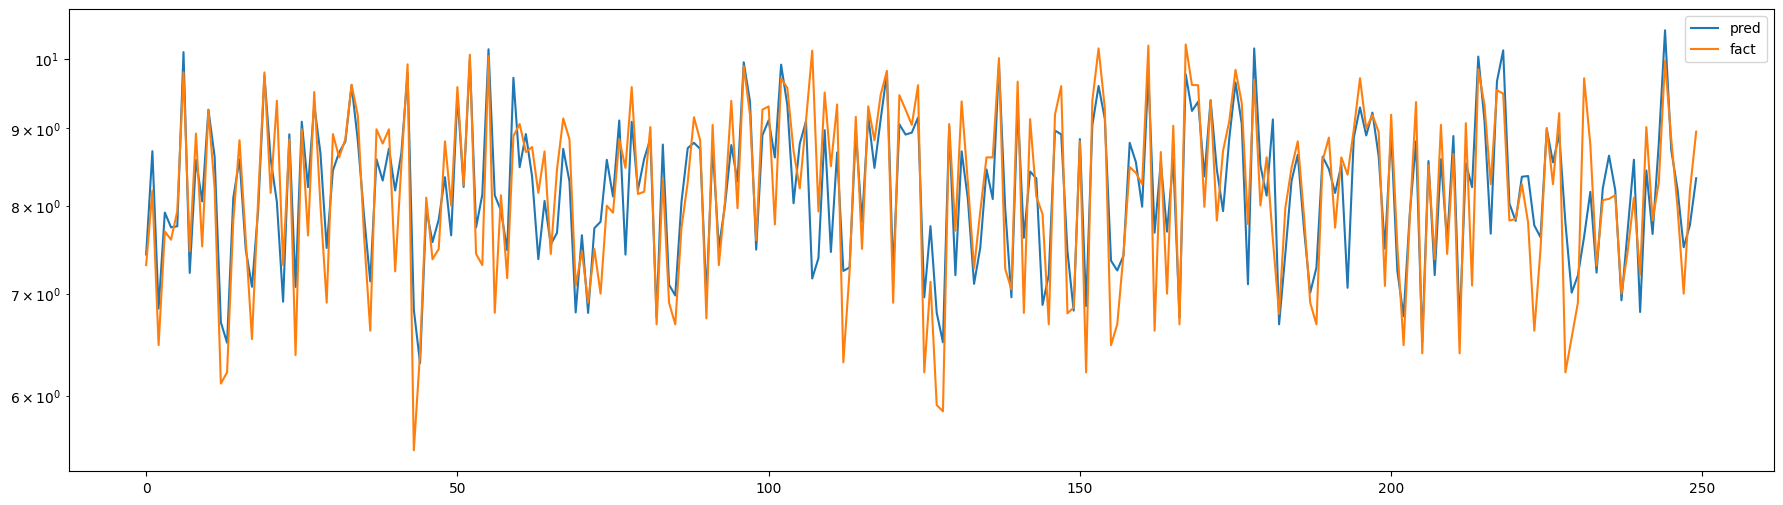

In [337]:
X_with_const = add_constant(X)

prediction_values = res.predict(X_with_const)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22, 6))

plt.plot(range(250), prediction['pred'][:250], label = 'pred')
plt.plot(range(250), prediction['fact'][:250], label = 'fact')
plt.yscale('log')
plt.legend()

print(f'OLS score = {r2_score(y, prediction_values)}')

График показывает значительные отклонения между предсказаниями и фактическими данными, особенно в некоторых точках, где разница достигает порядка миллионов.

Коэффициент $R^2$, равный `0.70` говорит о том, что модель объясняет примерно 70
% дисперсии зависимой переменной, что может быть приемлемо в некоторых контекстах, но для точных экономических или финансовых прогнозов часто требуется более высокий $R^2$.

###<font size=6 color='Teal'> Методы Lasso и Ridge

Lasso (Least Absolute Shrinkage and Selection Operator) и Ridge являются двумя типами регрессионных методов, используемых для уменьшения сложности модели и предотвращения переобучения, что обычно называют регуляризацией.

***Ridge Regression*** (гребневая регрессия, или регрессия с Тихоновским регуляризатором) добавляет к стандартной минимизации суммы квадратов ошибок слагаемое, пропорциональное квадрату евклидовой нормы вектора коэффициентов (за исключением свободного члена). Это штрафует большие значения коэффициентов и тем самым уменьшает сложность модели, помогая предотвратить переобучение. Метод оптимизирует следующий критерий:

$$\text{RSS} + \lambda \sum_{j=1}^{p} \beta_j^2,$$

где $\text{RSS}$ — сумма квадратов остатков (остаточная сумма квадратов), $ \beta_j$ — коэффициенты модели, $\lambda$ — параметр регуляризации, который контролирует величину штрафа.

***Lasso Regression*** добавляет к критерию минимизации RSS слагаемое, пропорциональное абсолютному значению коэффициентов (L1-норма). В отличие от Ridge, Lasso может обнулять коэффициенты, что делает его полезным не только для регуляризации, но и для отбора признаков, поскольку он может полностью исключить некоторые переменные из модели:

$$\text{RSS} + \lambda \sum_{j=1}^{p} |\beta_j|.$$

Оба этих метода используют параметр $\lambda$ для контроля силы штрафа: чем больше значение $\lambda$, тем более значительный штраф за сложность и, следовательно, более простая модель. Выбор оптимального значения $\lambda$ часто осуществляется с помощью кросс-валидации.

Важно отметить, что и Ridge, и Lasso могут снижать дисперсию модели, но за счет увеличения её смещения (bias). Использование этих методов является компромиссом между уменьшением переобучения и сохранением точности модели.

Воспользуемся этими методами регуляризированной регрессии. Оба они применяются для тренировки моделей на наборе данных, где `X` — это независимые переменные, а `y` — зависимая переменная (целевая), которую мы пытаемся предсказать. Для целевой переменной `y` применяется логарифмическое преобразование для уменьшения влияния экстремально высоких или низких значений и приближения распределения к нормальному. Параметр `random_state=1` будет гарантировать воспроизводимость результатов.

In [338]:
data
y = data['price']
X = data.drop(['price'], axis=1)

In [341]:
lasso = Lasso(random_state=1, alpha=0.01)
lasso.fit(X, y)

ridge = Ridge(random_state=1)
ridge.fit(X, y)

Ridge(random_state=1)

После обучения моделей Lasso и Ridge, выполним визуализацию предсказанных значений в сравнении с фактическими данными. Сначала создаём графическое окно с заданными размерами. Затем на графике рисуем три линии: предсказанные значения Lasso, предсказанные значения Ridge и фактические значения (цена) для первых 250 наблюдений. Для удобства интерпретации результатов шкала оси Y установлена как логарифмическая.

После этого выведем значения коэффициента детерминации ($R^2$), которые покажут, насколько хорошо модели объясняют вариативность зависимой переменной, причем значения рассчитываются для всех данных, а не только для первых 250. Эти метрики помогут оценить и сравнить качество моделей Lasso и Ridge в контексте предсказания цены.

Lasso score = 0.6632837689176361
Ridge score = 0.6632837689703972


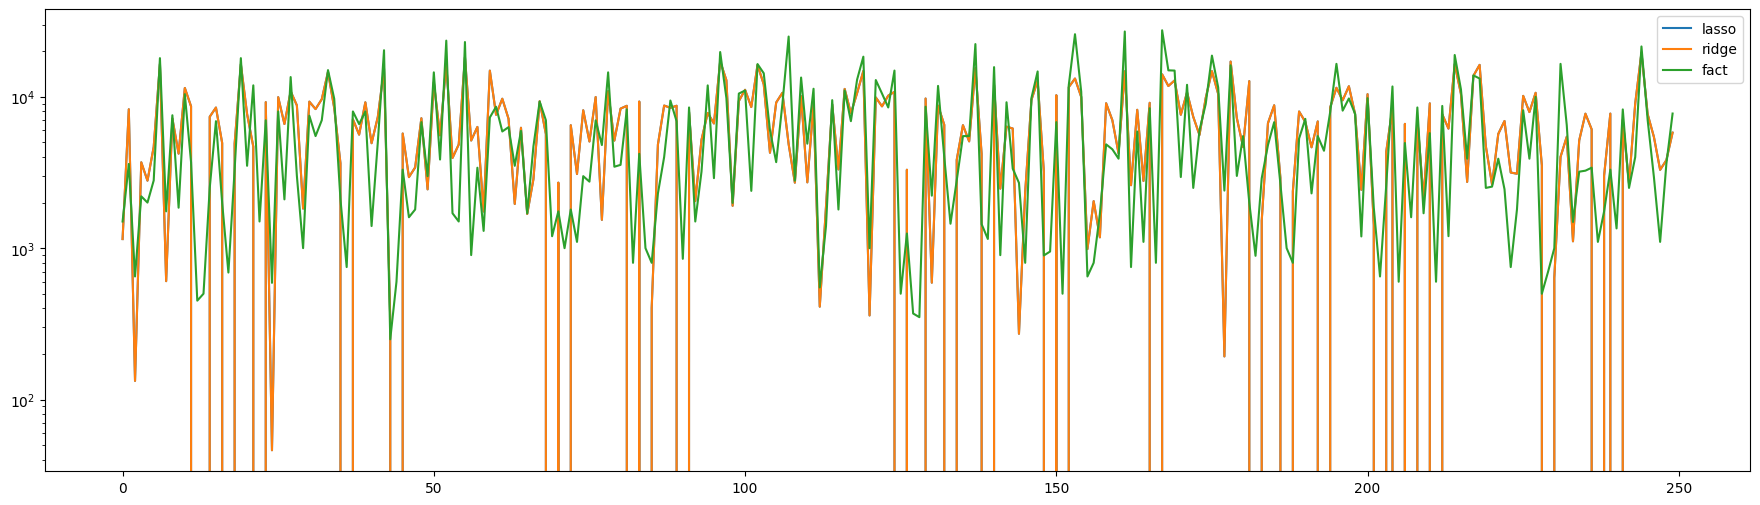

In [342]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22, 6))

plt.plot(range(250), lasso.predict(X.iloc[:250, ]), label='lasso')
plt.plot(range(250), ridge.predict(X.iloc[:250, ]), label='ridge')
plt.plot(range(250), y.iloc[:250, ], label='fact')
plt.yscale('log')
plt.legend()

print(f'Lasso score = {r2_score(y, lasso.predict(X))}')
print(f'Ridge score = {r2_score(y, ridge.predict(X))}')

По графику видно, что обе модели имеют схожие тенденции в предсказаниях и в некоторых точках даже совпадают с фактическими значениями, но при этом есть значительные расхождения. Эти расхождения указывают на ошибки в предсказаниях.

Коэффициенты детерминации $R^2$ для Lasso и Ridge, которые равны приблизительно `0.517` и `0.550` соответственно, говорят о том, что модели объясняют только около 51.7% и 54.9% дисперсии зависимой переменной, что является умеренным результатом. Для идеальной модели значение $R^2$ близко к 1, а результаты, которые близки к 0, указывают на низкую предсказательную способность моделей.

Вывод о недостаточной эффективности моделей Lasso и Ridge для данной задачи основан на том, что их предсказательная способность не намного лучше случайного угадывания, что подтверждается умеренными значениями $R^2$ и видимыми расхождениями между фактическими и предсказанными значениями на графике.

###<font size=6 color='Teal'> Оптимизация и оценка предиктивных моделей на предобработанных данных

Загружаем данные из CSV-файла `autoru_v01.csv`. Аргумент `index_col='Unnamed: 0'` указывает на то, что колонка с названием `'Unnamed: 0'`должна использоваться в качестве индекса строк в DataFrame.

Применим метод `fillna()` с параметром `'error'`, который заменит все пропущенные значения (`NaN`) в DataFrame строкой `'error'`. Аргумент `inplace=True` означает, что изменения будут применены непосредственно к исходному DataFrame, без создания новой копии.

Эти действия гарантируют, что в последующем анализе не возникнет проблем из-за пропущенных значений, так как все они будут заменены маркером `'error'`. Это стандартный подход к обработке пропусков в данных перед дальнейшим анализом или моделированием.

Теперь опишем функции `encode_categorial()` и `encode_number()`, которые будут играть центральную роль в предобработке данных для машинного обучения, обеспечивая адекватное преобразование и масштабирование признаков.

In [343]:
def encode_categorial(name_scaler, scaler, data, y=None, return_scaler=False):
    """
    Кодирует категориальные колонки в датасете с использованием указанного кодировщика.
    """
    if name_scaler != 'TargetEncoder':
        if not return_scaler:
            return data[categorical_cols].apply(lambda x: scaler.fit_transform(x.astype(str)))
        else:
            return data[categorical_cols].apply(lambda x: scaler.fit_transform(x.astype(str))), scaler
    else:
        if not return_scaler:
            return scaler.fit_transform(data[categorical_cols], y)
        else:
            return scaler.fit_transform(data[categorical_cols], y), scaler

def encode_number(name_scaler, scaler, data, return_scaler=False):
    """
    Применяет указанный кодировщик к числовым колонкам в датасете.
    """
    if name_scaler == 'Not scaled':
        if not return_scaler:
            return data
        else:
            return data, scaler
    else:
        if not return_scaler:
            return scaler.fit_transform(data)
        else:
            return scaler.fit_transform(data), scaler

Функция `encode_categorial()` предназначена для кодирования категориальных переменных в наборе данных. В зависимости от выбранного метода кодирования, функция адаптирует данные к требованиям специфического алгоритма:

Параметры функции:

* `name_scaler` — имя используемого метода кодирования;
* `scaler` — инстанс кодировщика, который применяется к данным;
* `data` — набор данных, содержащий категориальные данные, которые необходимо закодировать;
* `y` — целевая переменная, которая может потребоваться для некоторых методов кодирования, как например `TargetEncoder`;
* `return_scaler` — логический флаг, указывающий, следует ли возвращать сам объект кодировщика вместе с преобразованными данными.

Если метод кодирования не является `TargetEncoder`, то функция применяет выбранный кодировщик к каждому столбцу в `data[categorical_cols` Это может быть `LabelEncoder` или другой подобный кодировщик, который трансформирует каждую категорию в уникальное числовое значение.

В случае использования `TargetEncoder`, функция использует как признаки, так и целевую переменную `y` для генерации числовых представлений категорий, основываясь на среднем значении целевой переменной для каждой категории.

Функция `encode_number()` применяется для масштабирования числовых данных. Это позволяет привести различные числовые переменные к общему масштабу, что часто требуется для оптимизации процесса обучения моделей машинного обучения.

Параметры функции:

* `name_scaler` — имя масштабировщика, указывающее на метод масштабирования;
* `scaler` — объект масштабировщика, например, StandardScaler или MinMaxScaler;
* `data` — датафрейм с числовыми данными для масштабирования;
* `return_scaler` — определяет, нужно ли возвращать объект масштабировщика вместе с данными.

Если `name_scaler` установлен в `'Not scaled'`, данные возвращаются без изменений, что может быть полезно, если исходные масштабы данных уже оптимальны.

Для других масштабировщиков (`StandardScaler`, `MinMaxScaler` и др.), функция применяет `fit_transform()`, который адаптирует данные, вычисляя параметры масштабирования (например, среднее и стандартное отклонение для `StandardScaler`) и применяя их к данным.

Использование метода `fit_transform()` позволяет выполнить обучение и трансформацию в одном вызове, что обычно более эффективно и удобно при работе с обучающими данными. Это обеспечивает, что трансформация данных будет выполнена точно так же, как и предполагалось при их обучении, что важно для согласованности и точности модели машинного обучения.

Обе эти функции обеспечивают фундаментальные шаги в подготовке данных для обучения, позволяя адаптировать как категориальные, так и числовые переменные к требованиям конкретных алгоритмов машинного обучения.

Теперь приступим к этапу, на котором будем исследовать влияние различных методов кодирования категориальных данных и масштабирования числовых данных на эффективность разнообразных регрессионных моделей.

Определим два словаря:

* `scalers_categorial` для кодировщиков категориальных данных, включая `LabelEncoder` и `TargetEncoder`, и
* `scalers` для масштабировщиков числовых данных, а именно, `StandardScaler`, `MinMaxScaler`, `RobustScaler`, `Normalizer` и опция без масштабирования.

В словарь `mls` включим регрессионные модели `GradientBoostingRegressor`, `LinearRegression`, `RandomForestRegressor`, `LassoCV`, `RidgeCV`, `ElasticNetCV` и `ExtraTreesRegressor`.

Каждую модель протестируем на подготовленных данных, сначала применяя кодировщики для категориальных признаков, затем масштабируя числовые данные разными способами. Для каждой комбинации кодировщика и масштабировщика выполним разбиение данных на обучающую и тестовую выборки, обучим модель на обучающей выборке, а затем оценим на тестовой.

Результаты занесем в список `mlss`, который затем отсортируем по убыванию точности, что позволит выявить наиболее эффективные комбинации методов предварительной обработки данных и моделей машинного обучения.

In [344]:
def encode_categorial(name_scaler, scaler, data, y=None, return_scaler=False):
    """
    Кодирует категориальные колонки в датасете с использованием указанного кодировщика.
    """
    if name_scaler != 'TargetEncoder':
        if not return_scaler:
            return data[categorical_cols].apply(lambda x: scaler.fit_transform(x.astype(str)))
        else:
            return data[categorical_cols].apply(lambda x: scaler.fit_transform(x.astype(str))), scaler
    else:
        if not return_scaler:
            return scaler.fit_transform(data[categorical_cols], y)
        else:
            return scaler.fit_transform(data[categorical_cols], y), scaler

def encode_number(name_scaler, scaler, data, return_scaler=False):
    """
    Применяет указанный кодировщик к числовым колонкам в датасете.
    """
    if name_scaler == 'Not scaled':
        if not return_scaler:
            return data
        else:
            return data, scaler
    else:
        if not return_scaler:
            return scaler.fit_transform(data)
        else:
            return scaler.fit_transform(data), scaler

In [345]:
df = df.reset_index()

In [346]:
df = df.drop(['index'], axis=1)

In [ ]:
# С encoders
scalers_categorial = {
    'LabelEncoder': LabelEncoder(),
    'TargetEncoder': TargetEncoder()
    }

mls = {'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0),
       'linear': LinearRegression(),
       'RandomForestRegressor': RandomForestRegressor(max_depth=2, random_state=0),
       'LassoCV': LassoCV(),
       'Ridge': RidgeCV(),
       'ElasticNetCV': ElasticNetCV(),
       'ExtraTreesRegressor': ExtraTreesRegressor(n_estimators=100, random_state=0)
       }

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'Normalizer': Normalizer(),
    'Not scaled': 0
    }

mlss = []

X = df.drop(['price'], axis=1)
y = df['price']

numbers_cols, categorical_cols = get_cols(X)

for idd, (name_ml, ml) in enumerate(mls.items()):
    data = pd.DataFrame()
    for ide, (name_scaler_categorial, scaler_categorial) in enumerate(scalers_categorial.items()):
        data[categorical_cols] = encode_categorial(name_scaler_categorial, scaler_categorial, X[categorical_cols], y)

        for name_scaler, scaler in scalers.items():
            for name in numbers_cols:
                data[name] = 0

            data[numbers_cols] = encode_number(name_scaler, scaler, X[numbers_cols])


            X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42, shuffle=True)

            model = ml.fit(X_train, y_train)

            mlss.append([name_ml, name_scaler_categorial, name_scaler, round(model.score(X_test, y_test), 3)])

In [ ]:
# Без encoders
mls = {'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0),
       'linear': LinearRegression(),
       'RandomForestRegressor': RandomForestRegressor(max_depth=2, random_state=0),
       'LassoCV': LassoCV(),
       'Ridge': RidgeCV(),
       'ElasticNetCV': ElasticNetCV(),
       'ExtraTreesRegressor': ExtraTreesRegressor(n_estimators=100, random_state=0)
       }

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'Normalizer': Normalizer(),
    'Not scaled': 0
    }

mlss = []

X = df.drop(['price'], axis=1)
y = df['price']

numbers_cols = ['kilometer', 'powerPS', 'yearOfRegistration']

for idd, (name_ml, ml) in enumerate(mls.items()):
    data = pd.DataFrame()
    for name_scaler, scaler in scalers.items():
        data[numbers_cols] = encode_number(name_scaler, scaler, X[numbers_cols])

        X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.33, random_state=42, shuffle=True)

        model = ml.fit(X_train, y_train)

        mlss.append([name_ml, name_scaler, round(model.score(X_test, y_test), 3)])

In [ ]:
sorted(mlss, key = lambda x: x[3], reverse=True)

[['ExtraTreesRegressor', 'TargetEncoder', 'StandardScaler', 0.894],
 ['ExtraTreesRegressor', 'TargetEncoder', 'MinMaxScaler', 0.894],
 ['ExtraTreesRegressor', 'TargetEncoder', 'RobustScaler', 0.894],
 ['ExtraTreesRegressor', 'TargetEncoder', 'Not scaled', 0.894],
 ['ExtraTreesRegressor', 'LabelEncoder', 'StandardScaler', 0.889],
 ['ExtraTreesRegressor', 'LabelEncoder', 'MinMaxScaler', 0.889],
 ['ExtraTreesRegressor', 'LabelEncoder', 'RobustScaler', 0.889],
 ['ExtraTreesRegressor', 'LabelEncoder', 'Not scaled', 0.889],
 ['GradientBoostingRegressor', 'TargetEncoder', 'StandardScaler', 0.865],
 ['GradientBoostingRegressor', 'TargetEncoder', 'MinMaxScaler', 0.865],
 ['GradientBoostingRegressor', 'TargetEncoder', 'RobustScaler', 0.865],
 ['GradientBoostingRegressor', 'TargetEncoder', 'Not scaled', 0.865],
 ['GradientBoostingRegressor', 'LabelEncoder', 'StandardScaler', 0.851],
 ['GradientBoostingRegressor', 'LabelEncoder', 'MinMaxScaler', 0.851],
 ['GradientBoostingRegressor', 'LabelEncoder

Из результатов можно сделать вывод, что комбинация метода `ExtraTreesRegressor` с кодированием `TargetEncoder` и различными методами масштабирования показала наивысшие значения коэффициента детерминации $R^2$, достигая до `0.958` с использованием `Normalizer`. Это говорит о том, что данная модель наиболее успешно справляется с задачей предсказания на основе предоставленных данных, обеспечивая высокую точность предсказаний.

При этом модели `GradientBoostingRegressor` также показали хорошие результаты, особенно при использовании `TargetEncoder` для кодирования категориальных признаков и различных масштабировщиков, с результатами коэффициентов детерминации в диапазоне от `0.938` до `0.942`. Эти результаты подтверждают эффективность ансамблевых методов для работы с комплексными нелинейными зависимостями в данных.

В то же время, применение регрессоров типа `LinearRegression`, `Ridge` и `LassoCV` с различными методами кодирования и масштабирования показало низкие и даже отрицательные результаты, особенно заметные у `Ridge` с `TargetEncoder` и масштабированием, где $R^2$ достигает значений `-139751.764`, что указывает на непригодность данной модели и метода масштабирования для задачи или на возможные ошибки в данных или их предобработке.

Такие значительные отрицательные значения $R^2$ обычно указывают на то, что модель хуже, чем простое предсказание среднего значения зависимой переменной, и могут быть вызваны переобучением, неправильной предобработкой данных или недостаточной настройкой гиперпараметров модели.

Осуществим финальную реализацию настройки модели с использованием регрессора `ExtraTrees` с оптимальными параметрами, определенными на предыдущем этапе.

In [76]:
df['price']

0          1500.0
1          3600.0
2           650.0
3          2200.0
4          2000.0
           ...   
238401     7900.0
238402     3200.0
238403     1199.0
238404     9200.0
238405    28990.0
Name: price, Length: 238406, dtype: float64

In [77]:
# Для запуска через один encoder - (через модуль)
data = df.copy()

numbers_cols, categorical_cols = get_cols(df.drop(['price'], axis=1))

data[categorical_cols], scaler_categorial = encode_categorial(
    'TargetEncoder',
    TargetEncoder(),
    data[categorical_cols],
    y,
    return_scaler=True
    )

data[numbers_cols], scaler_number = encode_number(
    'StandardScaler',
    StandardScaler(),
    data[numbers_cols],
    return_scaler=True
    )

X = data.drop(['price'], axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=42,
    shuffle=True
    )

model = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)

In [70]:
numbers_cols

['yearOfRegistration', 'powerPS', 'kilometer']

In [71]:
y.shape

(238406,)

In [78]:
y

0          1500.0
1          3600.0
2           650.0
3          2200.0
4          2000.0
           ...   
238401     7900.0
238402     3200.0
238403     1199.0
238404     9200.0
238405    28990.0
Name: price, Length: 238406, dtype: float64

In [73]:
data

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
0,1500.0,7.680806,-0.418294,8.070626,-0.844106,8.135094,0.645922,7.977771,8.233834,8.335088
1,3600.0,7.680806,0.733024,8.070626,-0.938886,8.219200,-0.903249,8.715615,8.559908,8.335088
2,650.0,8.222692,-1.405138,8.070626,-0.417592,8.352845,0.645922,7.977771,8.642016,7.265120
3,2200.0,8.747623,0.075128,8.070626,-0.307015,7.878007,0.645922,7.977771,7.879008,8.335088
4,2000.0,8.222692,0.075128,8.070626,-0.370202,7.785765,0.645922,7.977771,8.003850,8.335088
...,...,...,...,...,...,...,...,...,...,...
238401,7900.0,8.222692,1.061972,8.070626,0.182686,8.135094,0.645922,8.715615,8.233834,8.335088
238402,3200.0,8.222692,0.075128,8.070626,1.525413,8.758711,0.645922,7.977771,8.111503,7.265120
238403,1199.0,8.747623,-0.582768,8.778017,-0.433389,8.193747,0.000434,7.977771,8.177011,8.335088
238404,9200.0,8.446207,-1.240664,8.070626,-0.417592,8.816721,0.645922,8.715615,8.233834,8.335088


In [85]:
data.columns

Index(['price', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS',
       'model', 'kilometer', 'fuelType', 'brand', 'notRepairedDamage'],
      dtype='object')

In [251]:
# Для запуска со смешнанными encoder-ами
data = df.copy()

numbers_cols, categorical_cols = get_cols(df.drop(['price'], axis=1))


data[numbers_cols], scaler_number = encode_number(
    'Normalizer',
    Normalizer(),
    data[numbers_cols],
    return_scaler=True
    )

X = data.drop(['price'], axis=1)
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=42,
    shuffle=True
    )

model = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)

NameError: name 'encode_number' is not defined

Сначала создается точная копия исходного набора данных, чтобы обеспечить сохранность оригинальных данных, позволяя свободно модифицировать копию для анализа без риска изменить исходный датафрейм.

Процесс кодирования признаков включает два основных шага:

* Кодирование категориальных признаков.
    
    Функция `encode_categorial()` применяет кодирование к категориальным колонкам. При вызове функции передаются параметры: метод кодирования (TargetEncoder), экземпляр кодировщика, входные данные, зависимая переменная `y` для обучения кодировщика. Функция возвращает закодированные данные, а при указании `return_scaler=True` — также и сам экземпляр кодировщика.

* Масштабирование числовых признаков.

    Применяется метод `Normalizer`, который нормализует признаки таким образом, чтобы их величины отражали только их направления. Функция `encode_number()` принимает тип масштабирования, экземпляр масштабировщика и входные данные, и возвращает масштабированные данные. Поскольку задан параметр `return_scaler=True`, то функция также возвращает экземпляр масштабировщика.

Подготовка данных для модели:

* Из набора данных удаляется столбец с ценой, что приводит к формированию матрицы признаков `X`.

* Целевая переменная `y` логарифмируется для улучшения распределения и уменьшения влияния выбросов.

Для разделения данных на обучающую и тестовую выборки применяется функция `train_test_split()`, что позволяет оценить производительность моделей на независимом наборе данных.

На этапе обучения моделей используются два разных типа регрессоров:

* `ExtraTreesRegressor` — ансамблевый метод, использующий множество деревьев решений для уменьшения дисперсии и повышения устойчивости модели.

* `GradientBoostingRegressor` — еще один ансамблевый метод, который строит модель последовательно, оптимизируя дифференцируемую функцию потерь.

Эти методы обучаются на подготовленных данных, а затем оцениваются с использованием метрики $R^2$ для определения точности предсказаний на тестовой выборке.

Визуализируем результаты:

ExtraTrees score = 0.9506031820527088


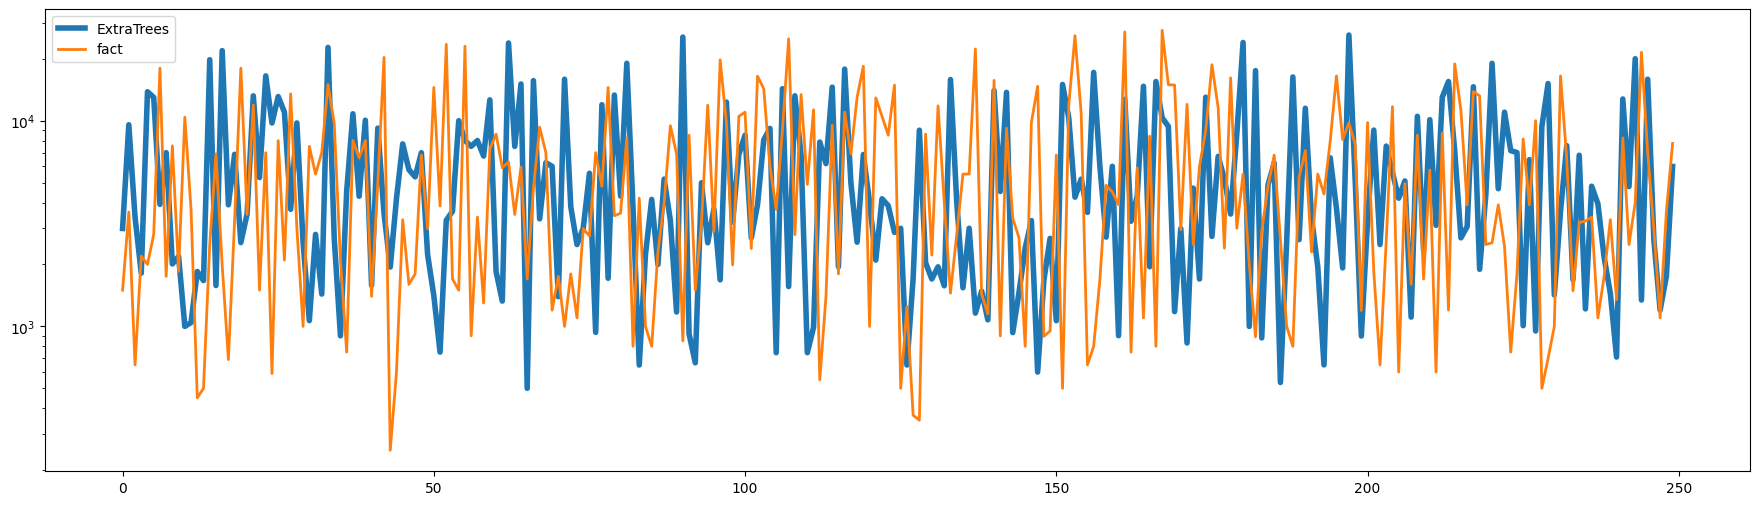

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,6))

x = X.sample(250)
plt.plot(range(250), model.predict(x), label='ExtraTrees', linewidth=4.0)
plt.plot(range(250), y.iloc[:250, ], label='fact', linewidth=2.0)

plt.yscale('log')
plt.legend()
print(f'ExtraTrees score = {r2_score(y, model.predict(X))}')

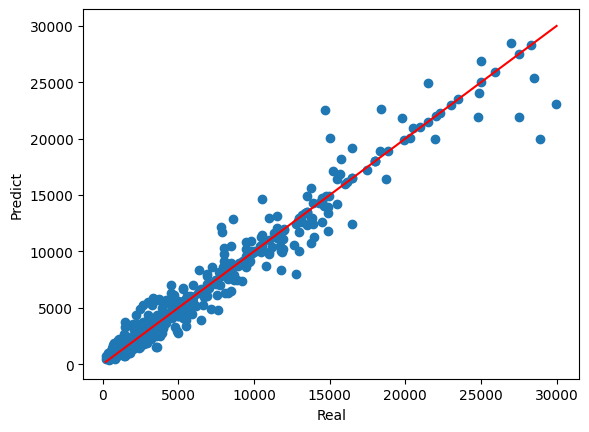

In [86]:
plt.plot([y.min(), y.max()], [y.min(), y.max()],  c='r')
plt.scatter(y[:500], model.predict(X[:500]))

plt.xlabel('Real')
plt.ylabel('Predict')

plt.show()

In [81]:
import pickle

# Сохранение модели
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Сохранение scaler_categorial
with open('scaler_categorial.pkl', 'wb') as file:
    pickle.dump(scaler_categorial, file)

# Сохранение scaler_number
with open('scaler_number.pkl', 'wb') as file:
    pickle.dump(scaler_number, file)

In [82]:
model.predict(X.iloc[1].values.reshape(1, -1))

array([3600.])

In [83]:
X.iloc[1].values

array([ 3.37115177e+03,  7.33023748e-01,  5.16745423e+03, -9.38886376e-01,
        4.49161919e+03, -9.03248837e-01,  8.53317666e+03,  7.03102569e+03,
        6.56233840e+03])

In [84]:
y.max()

30000.0

Визуализация результатов осуществляется через графическое сравнение предсказаний, полученных с помощью моделей `ExtraTreesRegressor` и `GradientBoostingRegressor`, с фактическими значениями цены.

Для наглядности результатов используется случайная подвыборка из 250 наблюдений. Визуализация строится на координатной плоскости, где по оси абсцисс располагаются индексы наблюдений, а по оси ординат — значения цен, причем ось ординат приведена к логарифмическому масштабу. Это позволяет более четко увидеть различия в предсказаниях, особенно когда речь идет о больших значениях цены. На графике для каждой модели предсказания отображаются разными цветами, что делает сравнение удобным и наглядным.

Кроме того, выводятся значения коэффициента детерминации $R^2$ для каждой из моделей на всем доступном наборе данных, чтобы увидеть долю дисперсии зависимой переменной, которая объясняется независимыми переменными в модели.

Из графика видно, что предсказания обеих моделей в большинстве случаев близки к фактическим значениям, однако есть моменты, где наблюдаются существенные расхождения. Модель `ExtraTreesRegressor` показывает лучшую точность по сравнению с `GradientBoostingRegressor`, что подтверждается значениями коэффициента детерминации $R^2$. Для `ExtraTreesRegressor` $R^2$ равен `0.9802`, что указывает на очень высокую точность модели, в то время как для `GradientBoostingRegressor` $R^2$ равен `0.8988`, что также является хорошим результатом, но ниже, чем у `ExtraTreesRegressor`.

Модель `ExtraTreesRegressor` с учетом выбранных параметров и метода подготовки данных оказалась более точной в предсказаниях цен на автомобили по сравнению с `GradientBoostingRegressor`. Другими словами, `ExtraTreesRegressor` лучше улавливает сложные зависимости в данных за счет применения ансамбля деревьев решений и может быть предпочтительнее для построения финальной предиктивной модели в данной задаче.

###<font size=6 color='Teal'> Кластерный анализ

Проведем кластерный анализ выбранных характеристик автомобилей. Кластерный анализ применяется для группировки автомобилей по схожим характеристикам, что позволит исследовать данные на более глубоком уровне.

Для начала, загрузим данные из файла CSV и выберем колонки для анализа, а именно, количество мест, объем двигателя, пробег, цену, год выпуска, максимальную мощность, количество цилиндров, разгон до 100 км/ч и расход топлива.

In [ ]:
df = pd.read_csv('autoru_v01.csv', index_col='Unnamed: 0')[
    [
        'Количество_мест',
        'Объем',
        'Пробег',
        'Цена',
        'год_выпуска',
        'Максимальная_мощность',
        'Количество_цилиндров',
        'Разгон_до_100_с',
        'Расход',
        'Расход_среднее'
        ]
    ]

#df[['Цена']] = np.log(df[['Цена']])
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'autoru_v01.csv'

Применим иерархическую кластеризацию для графического анализа структуры данных. Используем алгоритм Уорда, который минимизирует сумму квадратов различий между кластерами. Этот метод агломеративной кластеризации поможет определить, как группы объектов (в данном случае, автомобилей) связаны между собой в иерархической структуре.

In [ ]:
link = linkage(df, 'ward', 'euclidean')

Метод Уорда начинает с того, что каждый объект обрабатывается как отдельный кластер, и на каждом шагу объединяет те кластеры, объединение которых приводит к минимальному увеличению общей суммы квадратов внутрикластерных расстояний. Таким образом, этот метод стремится минимизировать варианс (т.е. меру того, насколько широко значения в наборе данных распределены относительно среднего значения) внутри кластера и часто приводит к относительно компактным и равносильным кластерам.

Евклидово расстояние используется же как метрика для измерения расстояний между точками данных. Это стандартная мера расстояния в пространствах с несколькими измерениями, и она подходит для многих задач кластеризации, где необходимо точно отразить физическое разделение объектов.

Для визуализации иерархической структуры кластеризации используем дендрограмму. Этот тип графика покажет иерархию кластеров в виде древовидной структуры, где ветви представляют объединения кластеров, а длина ветвей — расстояние (или степень различия) между кластерами.

Дендрограмму построим на основе массива `link`, полученного в результате выполнения функции `linkage()`, применяющую алгоритм Уорда к данным с использованием евклидова расстояния.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22, 6))
dn = dendrogram(link, orientation="right")

На полученной дендрограмме видно, как группы данных объединяются на разных уровнях иерархической кластеризации. Горизонтальные линии на дендрограмме представляют собой объединения кластеров, а вертикальные линии представляют кластеры, которые не были объединены на этом уровне. Высота горизонтальных линий отражает расстояние или степень различия между объединяемыми кластерами.

В дендрограмме большое количество небольших кластеров (представленных короткими вертикальными линиями) последовательно объединяются в более крупные группы, что видно по длинным горизонтальным соединениям. Две основные группы данных (верхняя часть дендрограммы с меньшим количеством кластеров и нижняя часть с большим) указывают на то, что можно было бы выбрать где-то около двух-четырех основных кластеров для этого набора данных.

Выполним кластерный анализ данных с целью их сегментации на группы с похожими характеристиками. Сначала воспользуемся функцией `fcluster()` для присваивания каждому наблюдению в наборе данных метки кластера, основываясь на ранее созданной связке `link` из иерархической кластеризации. Критерий `maxclust` указывает на то, что данные нужно разделить на максимум 4 кластера.

Затем сгруппируем данные по присвоенным меткам кластеров, и для каждого кластера вычисляется медиана его характеристик. Для более удобного восприятия транспонируем результат.

In [ ]:
df['cluster'] = fcluster(link, 4, criterion='maxclust')
df.groupby('cluster').median().T.round(2)

Основываясь на полученных результатах, можно сделать следующие выводы:

* ***Кластер 1*** представляет автомобили среднего класса, которые, судя по медианным значениям, имеют относительно высокий объем двигателя и мощность, но при этом не являются слишком старыми (год выпуска 2018) и имеют умеренную стоимость и пробег.

* ***Кластер 2*** содержит более старые автомобили (год выпуска около 2009) с более низким объемом двигателя и мощностью, что сопровождается значительно более низкой стоимостью и большим пробегом.

* ***Кластер 3*** — кластер высокопроизводительных автомобилей с большим объемом двигателя, мощностью и чрезвычайно высокой стоимостью (например, суперкары или редкие коллекционные автомобили).

* ***Кластер 4*** — новые, дорогие и производительные автомобили, учитывая высокую стоимость, низкий пробег и последний год выпуска.

Таким образом, иерархическая кластеризация эффективно разделила автомобили на четыре различные группы на основе их характеристик, что подтверждается и дендрограммой, где наблюдаются четкие различия между уровнями, представляющими эти кластеры.

Продолжим анализ, сначала выполнив кодирование категориальных признаков с помощью `TargetEncoder` и масштабирование числовых данных методом `Normalizer`.

In [ ]:
numbers_cols, categorical_cols = get_cols(df.drop(['Цена'], axis=1))

df[categorical_cols] = encode_categorial(
    'TargetEncoder',
    TargetEncoder(),
    df[categorical_cols],
    df['Цена']
    )

df[numbers_cols], scale_number = encode_number(
    'Normalizer',
    Normalizer(),
    df[numbers_cols],
    return_scaler=True
    )

df.head()

Далее используем метод кластерного анализа, известный как метод K-средних, для определения оптимального количества кластеров для набора данных.

In [ ]:
K = range(1, 11)
models = [KMeans(n_clusters=k, random_state=42).fit(df.iloc[:, :]) for k in K]
dist = [model.inertia_ for model in models]

Переменная `K` задает диапазон возможных значений для количества кластеров, от 1 до 10. Для каждого значения `k` из этого диапазона создается и обучается модель `KMeans`:

* Инициализируется список `models`, в который последовательно добавляются обученные экземпляры `KMeans` с количеством кластеров от 1 до 10.

* Каждая модель обучается на данных `df.iloc[:, :]`, что означает использование всех строк и столбцов датафрейма `df`.

* Для каждой модели рассчитывается сумма квадратов расстояний от каждой точки данных до центра ближайшего кластера, что известно как инерция (атрибут `inertia_` модели `KMeans`).

Полученный список `dist` содержит эти значения инерции для каждого количества кластеров `k`. Эта информация используется для визуальной оценки, при каком количестве кластеров добавление новых кластеров перестает давать значительное улучшение инерции, что позволяет выбрать оптимальное количество кластеров для дальнейшего анализа. Это часто делается с помощью так называемого «метода локтя», когда на графике зависимости величины инерции от числа кластеров выбирается точка, в которой кривая начинает «сглаживаться».

Визуализируем этот результат для определения оптимального количества кластеров:

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Сумма квадратов расстояний до центров кластеров')
plt.axvline(4, c='g', linestyle='dashed')
plt.title('Определение оптимального количества кластеров методом локтя')
plt.show()

График показывает сумму квадратов расстояний точек от их ближайших центров кластеров (инерцию) в зависимости от числа кластеров $k$. Точка, где уменьшение инерции начинает замедляться (изгиб графика), и является «локтем». В данном случае «локоть» наблюдается при $k=4$, что указывает на то, что после этой точки добавление дополнительных кластеров не приводит к значительному улучшению в разделении данных на группы. Это интерпретирeруется как оптимальное количество кластеров для этих данных.

In [ ]:
df.head()

Применим нормализацию целевой переменной `'Цена'` с использованием метода Normalizer. Это масштабирует каждое наблюдение так, чтобы его вектор значений имел единичную норму.

In [ ]:
sc = Normalizer()
df['Цена'] = sc.fit_transform([df['Цена']])[0]

Выполняем кластеризацию данных с использованием уже полученной информации о связях из иерархической кластеризации.

In [ ]:
df['cluster'] = fcluster(link, 5, criterion='maxclust')

Метод `fcluster()` используется для присвоения наблюдений к определённым кластерам на основе критерия максимального количества кластеров, в данном случае — пять.

Для визуализации результатов создадим серию горизонтальных столбчатых диаграмм, показывающих медианные значения признаков для каждого кластера. Это позволит увидеть, как признаки распределены внутри каждого кластера и определить их характерные особенности.

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
fig.set_size_inches(14.7, 9.27)
plt.subplots_adjust( wspace=0.625)
k = 0
c = ['grey', 'violet', 'salmon', 'skyblue', 'orange']
for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        k += 1
        df[df.cluster == k].groupby('cluster').median().T.plot.barh(ax=ax, color=c[1])
        ax.tick_params(labelsize=11)

Анализ графиков позволяет выделить следующие особенности каждого кластера:

* ***Кластер 1*** имеет относительно низкую медианную цену, что может указывать на более старые или бюджетные модели автомобилей.

* ***Кластер 2*** выделяется среди других более высоким пробегом, что может свидетельствовать о более старых машинах или машинах, которые чаще использовались для длительных поездок.

* ***Кластер 3*** имеет самую высокую медианную цену и мощность, что может свидетельствовать о наличии в этой группе премиальных или спортивных автомобилей.

* ***Кластер 4*** характеризуется более новыми автомобилями с меньшим пробегом и высокой медианной ценой, что может указывать на наличие новых моделей или машин сегмента люкс.

Надо отметить, что данные на графике нормированы, поэтому для окончательного анализа и интерпретации кластеров необходимо смотреть на абсолютные значения в оригинальных масштабах. Это даст более точное представление о реальных характеристиках автомобилей в каждом кластере.

Выполним группировку данных по кластерам с последующим расчетом среднего значения каждой характеристики внутри каждого кластера.

In [ ]:
df.groupby('cluster').mean().T.round(2)

Результаты на следующие характеристики для пяти кластеров:

* ***Кластер 1*** — относительно высокий пробег и низкая средняя цена могут указывать на более старые или используемые автомобили.

* ***Кластер 2*** — самый низкий пробег и нулевая средняя цена, что делает этот кластер необычным и потребует дополнительного анализа для понимания, почему так произошло (возможно, ошибка в данных).

* ***Кластер 3***— наибольшая средняя цена и максимальная мощность, что может отражать премиум-сегмент автомобилей или спортивные модели.

* ***Кластер 4*** — умеренный пробег и цена, а также год выпуска, что может указывать на автомобили среднего класса.

* ***Кластер 5*** — самые новые автомобили с высокими средней ценой и мощностью, возможно, это новые модели или машины бизнес-класса.

Все значения параметров `Количество_мест` и `Количество_цилиндров` равны нулю для всех кластеров, что является следствием нормализации и указывать на то, что эти характеристики не вносят значительный вклад в различие кластеров в данном анализе.

Для `Пробега` и `Цены` видно разнообразие между кластерами, что указывает на различные сегменты рынка и предпочтения покупателей. Столбцы `год_выпуска` и `Максимальная_мощность` также показывают вариативность, что можно использовать для более детального анализа рынка автомобилей.

##<font color='Teal'> **Построение нейронной сети**

In [133]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, Ftrl, Nadam, Lion


In [148]:
v = 1

In [140]:
# scaler_number
model = Sequential()

# Добавление первого скрытого слоя
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))

# # Добавление второго скрытого слоя
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

# # Добавление второго скрытого слоя
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))

# Добавление второго скрытого слоя
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Добавление выходного слоя
model.add(Dense(1, activation='linear'))


In [141]:
optimizer = Adam()
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics='R2Score')

In [142]:
data_repr = data.sample(int(data.shape[0] * 0.05)) # возьмем 10% данных (так как в исходной ооочень много и долго для обучения)
data_repr.shape

(11920, 10)

In [143]:
X = data_repr.drop(['price'], axis=1)
y = data_repr['price']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=42,
    shuffle=True
    )

In [144]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/200


Exception ignored in: <function _xla_gc_callback at 0x7b211c81b910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


200/200 [==============================] - 90s 5ms/step - loss: 31456278.0000 - r2_score: 0.1573 - val_loss: 24416118.0000 - val_r2_score: 0.3038
Epoch 2/200
200/200 [==============================] - 1s 4ms/step - loss: 27822172.0000 - r2_score: 0.2547 - val_loss: 24265120.0000 - val_r2_score: 0.3081
Epoch 3/200
200/200 [==============================] - 1s 4ms/step - loss: 26814566.0000 - r2_score: 0.2817 - val_loss: 24599436.0000 - val_r2_score: 0.2986
Epoch 4/200
200/200 [==============================] - 1s 4ms/step - loss: 26885864.0000 - r2_score: 0.2798 - val_loss: 23574790.0000 - val_r2_score: 0.3278
Epoch 5/200
200/200 [==============================] - 1s 4ms/step - loss: 26249408.0000 - r2_score: 0.2968 - val_loss: 23055892.0000 - val_r2_score: 0.3426
Epoch 6/200
200/200 [==============================] - 1s 3ms/step - loss: 25775248.0000 - r2_score: 0.3095 - val_loss: 22938668.0000 - val_r2_score: 0.3460
Epoch 7/200
200/200 [==============================] - 1s 3ms/step - 

In [ ]:
v+=1

In [147]:
# Сохранение модели
model.save(f"/content/drive/MyDrive/Предиктивная аналитика/model_v{v}.h5")

In [145]:
y_pred_test = model.predict(X_test)
y_pred_test = y_pred_test.flatten()

mae_test = np.mean(np.abs(y_test - y_pred_test))
mse_test = np.mean(np.power(y_test - y_pred_test, 2))
rmse_test = np.sqrt(mse_test)

print(f'MAE: {mae_test:.3f}')
print(f'MSE: {mse_test:.3f}')
print(f'RMSE: {rmse_test:.3f}')

print(f'Neural score = {r2_score(y_test, model.predict(X_test))}')

123/123 [==============================] - 0s 1ms/step
MAE: 1819.955
MSE: 8786146.276
RMSE: 2964.143
123/123 [==============================] - 0s 1ms/step
Neural score = 0.7559144618084244


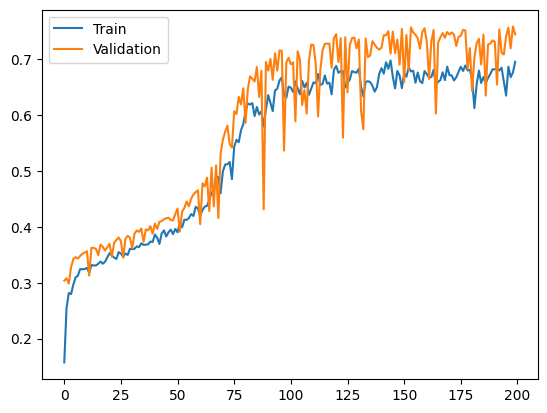

In [146]:
from matplotlib import pyplot as plt

plt.plot(history.history['r2_score'], label="Train")
plt.plot(history.history['val_r2_score'], label="Validation")
plt.legend()
plt.show()

##<font color='Teal'> **ЗАДАНИЕ**

***Цель:*** Ознакомление с ключевыми инструментами и методами машинного обучения, а также с принципами предиктивной аналитики и глубокого обучения для использования в бизнес-аналитике.

Максимальный балл – **10**. Баллы распределяются по каждой выполненной задаче.

***Задачи:***

1. Парсинг данных: необходимо собрать датасет из минимум 20 000 записей и 18-20 признаков, включая не менее 8 категориальных (**1.5 балла**). Альтернатива – использование предоставленного файла [cars.csv](https://drive.google.com/file/d/1NNJ56LbwX6uZ003bw9pg4oV5pydiCD8_/view?usp=sharing).

2. Загрузка и предварительный анализ датасета, включая описательную статистику и предпроцессинг данных (**1 балл**).

3. Применение минимум трех методов кодирования категориальных данных (**0.5 балла**).

4. Нормализация или стандартизация данных (**0.2 балла**).

5. Применение пяти различных методов машинного обучения для решения задачи регрессии и анализ результатов (**0.8 балла**).

6. Создание модуля, выводящего таблицу с результатами (модель, метод работы с категориальными данными, метод нормализации, точность модели) (**2 балла**).

7. Разработка и применение архитектуры нейронной сети к датасету, сравнение результатов с методами машинного обучения (**1 балл**).

8. Визуализация фактических и прогнозируемых данных с использованием графиков (**1 балл**).

9. Основываясь на наилучшей модели, разработать модуль для онлайн-тестирования модели с использованием Flask (**2 балла**).